In [35]:
import math
import sys
from pathlib import Path
import itertools
import kaleido
import pickle
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.express as px
import plotly.io as pio
from matplotlib import pyplot as plt
from matplotlib_venn import venn3, venn3_circles
from matplotlib_venn import venn2, venn2_circles
from venn import venn
from venn import generate_petal_labels, draw_venn, generate_colors
px.defaults.template = 'ggplot2'
px.defaults.template = 'simple_white'
pio.templates.default = 'simple_white'
cdr_colors = ["#74D2F5", "#5495D6", "#3763F5", "#CF81EB", "#E564F5", "#A04AD6",
    'Aqua', 'AquaMarine']

from collections import namedtuple, defaultdict, Counter

source_location = Path().resolve()
sys.path.append(source_location)

from abag_interactions_hydrophobic import *
from abag_interactions_rings import *
from more_utils import *
from names import *

casa_dir = Path("/home/pbarletta/labo/22/abag")
data_dir = Path.joinpath(casa_dir, "data")
str_dir = Path.joinpath(casa_dir, "structures/raw")
exposed_dir = Path.joinpath(casa_dir, "structures/exposed")

------

## Hydrophobic

In [67]:
with open(Path.joinpath(casa_dir, 'data', 'filenames.pkl'), 'rb') as file:
    filenames = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'chains.pkl'), 'rb') as file:
    chains = pickle.load(file)
with(open(Path.joinpath(data_dir, 'pdb.list'), 'r')) as file:
    pdb_list = [ linea.strip() for linea in file ]
with open(Path.joinpath(casa_dir, 'data', 'hydrophobic.pkl'), 'rb') as file:
     hydrophobic = pickle.load(file)

In [68]:
chain_type_dict = {'H': 0, 'K': 0, 'L': 0}
cdr_dict = {'H1': 0, 'H2': 0, 'H3': 0, 'L1': 0, 'L2': 0, 'L3': 0, 
'K1': 0, 'K2': 0, 'K3': 0, 'H0': 0, 'K0': 0, 'L0': 0}
cdr_dict_big_cluster = {'H1': 0, 'H2': 0, 'H3': 0, 'L1': 0, 'L2': 0, 'L3': 0, 
'K1': 0, 'K2': 0, 'K3': 0, 'H0': 0, 'K0': 0, 'L0': 0}
cdr_dict_big_cluster_aa_comp_atm = dict(zip(AA_LIST, itertools.repeat(0, 20)))
cdr_dict_big_cluster_aa_comp_res = dict(zip(AA_LIST, itertools.repeat(0, 20)))
size_largest_cluster_res = []
size_largest_cluster_atm = []
clusters_count = []
cdr_count_largest_cluster = []

for pdb_idcode in pdb_list:
    nbr_of_clusters = 0
    flag = True
    list_chain_type_cdr = []

    for cluster in hydrophobic[pdb_idcode]:
        # Don't count clusters of less than 4 carbon atoms.
        nbr_of_clusters += 1 if len(cluster) > 4 else 0
        for carbon in cluster:
            if carbon.chain_type != '.':
                chain_type_dict[carbon.chain_type] += 1
                
                chain_type_cdr = carbon.chain_type + str(carbon.CDR)
                cdr_dict[chain_type_cdr] += 1
                list_chain_type_cdr.append(chain_type_cdr)
        if flag:
            if nbr_of_clusters == 0:
                continue
            # Clusters are sorted by size, so the 1st one is the largest.
            for cdr, count in Counter(list_chain_type_cdr).items():
                cdr_dict_big_cluster[cdr] += count
            # Count aminoacid types, at an atomic level:
            for carbon in cluster:
                cdr_dict_big_cluster_aa_comp_atm[carbon.resname] += 1
            # Count aminoacid types, at residue level:
            unique_resi_list = set([
                 carbon.resname+carbon.chain_ID+carbon.resSeq_str for carbon in cluster])
            for residuo in unique_resi_list:
                resname = residuo[0:3]
                cdr_dict_big_cluster_aa_comp_res[resname] += 1
            
            size_largest_cluster_res.append(len(unique_resi_list))
            size_largest_cluster_atm.append(len(cluster))

            # Count the number of CDRs in the largest cluster
            cdrs_in_cluster = set([carbon.chain_ID + str(carbon.CDR)
                    for carbon in cluster if carbon.CDR not in (-1, 0)])
            # There's, like, 8 PDBs that are only interacting through framework.
            cdr_count = len(cdrs_in_cluster) if len(cdrs_in_cluster) > 0 else 1
            cdr_count_largest_cluster.append(cdr_count)
            flag = False
    if nbr_of_clusters > 0:
        clusters_count.append(nbr_of_clusters)

### origin_of_carbons_in_hydrophobic_interactions

In [69]:
fig_si = go.Figure(data = go.Pie(labels = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3'], 
    values = [cdr_dict['H1'], cdr_dict['H2'], cdr_dict['H3'],
    cdr_dict['L1']+cdr_dict['K1'], cdr_dict['L2']+cdr_dict['K2'],
    cdr_dict['L3']+cdr_dict['K3']],
    hole=0.6, pull=0.02, sort=False) )

fig_si.update_traces(marker={'colors': cdr_colors, 
    'line': {'color': 'black', 'width': 0.2}})

fig_si.update_layout(legend = {'x': .4, 'y': .5, 'orientation': 'v'})

fig_si.update_layout(font_size=19, width=500, height=500)

In [70]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_origin_of_carbons_in_hydrophobic_interactions.jpg"))

### origin_of_the_carbons_from_the_biggest_hydrophobic_cluster

In [71]:
fig_6c = go.Figure(data = go.Pie(labels = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3'], 
    values = [cdr_dict_big_cluster['H1'], cdr_dict_big_cluster['H2'],
    cdr_dict_big_cluster['H3'], cdr_dict_big_cluster['L1']+cdr_dict_big_cluster['K1'],
    cdr_dict_big_cluster['L2']+cdr_dict_big_cluster['K2'],
    cdr_dict_big_cluster['L3']+cdr_dict_big_cluster['K3']], 
    hole=0.6, pull=0.02, sort=False))

fig_6c.update_traces(marker={'colors': cdr_colors, 
    'line': {'color': 'black', 'width': 0.2}})

fig_6c.update_traces(marker={'colors': cdr_colors})
fig_6c.update_layout(legend = {'x': .4, 'y': .505})

fig_6c.update_layout(font_size=19, width=500, height=500)

In [72]:
fig_6c.write_image(Path.joinpath(casa_dir, "more_plots", "hydro_cdrs_fig6c.jpg"))

### number_of_clusters_per_PDB

In [93]:
fig_si = px.histogram(pd.DataFrame({'count':clusters_count}),
    histnorm = 'probability', x='count', labels={'count': "Number of clusters"})
fig_si.update_xaxes(tick0 = 1, dtick=1)

fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=500, height=500)

In [94]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_number_of_clusters_per_PDB.jpg"))

### size_of_the_largest_cluster_of_each_PDB_by_atm

In [91]:
mid_bins = list(range(8, 140, 20))
fig_6b = go.Figure()
fig_6b.add_trace(go.Histogram(x=size_largest_cluster_atm,
    xbins=dict(start=0, end=130.0, size=20),
    histnorm = 'probability'))
fig_6b.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(mid_bins),
        ticktext = list(mid_bins)
    )
)
fig_6b.update_layout(bargap = .01)
fig_6b.update_traces(marker = {'color': 'BurlyWood'})
fig_6b.update_layout(
    xaxis_title_text='Number of carbons in largest cluster',
    yaxis_title_text='Relative frequency')
fig_6b.update_layout(font_size=20, width=500, height=500)
fig_6b.show()

In [92]:
fig_6b.write_image(Path.joinpath(casa_dir, "more_plots", "hydro_carbons_in_biggest_cdrs_fig6b.jpg"))

### size_of_the_largest_cluster_of_each_PDB_by_res

In [89]:
mid_bins = list(range(2, 46, 4))
fig_si = go.Figure()
fig_si.add_trace(go.Histogram(x=size_largest_cluster_res,
    xbins=dict(start=0, end=42, size=4),
    histnorm = 'probability'))
fig_si.update_layout(
    xaxis = dict(
        tickmode = 'array',
        tickvals = list(mid_bins),
        ticktext = list(mid_bins)
    )
)
fig_si.update_layout(bargap = .01)
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(
    xaxis_title_text='Number of residues in the largest cluster',
    yaxis_title_text='Relative frequency')
fig_si.update_layout(font_size=20, width=500, height=500)
fig_si.show()

In [90]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_size_of_the_largest_cluster_of_each_PDB_by_res.jpg"))

### resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_atom

In [79]:
tot = sum(cdr_dict_big_cluster_aa_comp_atm.values())
cdr_dict_big_cluster_aa_comp_atm_ratio = {}
for aa, cnt in cdr_dict_big_cluster_aa_comp_atm.items():
    cdr_dict_big_cluster_aa_comp_atm_ratio[aa] = cnt/tot

In [87]:
df_aa_comp = pd.DataFrame({'AA': cdr_dict_big_cluster_aa_comp_atm_ratio.keys(),
    'Count': cdr_dict_big_cluster_aa_comp_atm_ratio.values()})
    
fig_si = px.histogram(df_aa_comp, x='AA', y='Count',
    height=400)
fig_si.update_xaxes(title = "Amino Acid")
fig_si.update_yaxes(title = "Count", range = [0, .3])
fig_si.update_layout(
    yaxis_title_text='Relative frequency')
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=800, height=500)
fig_si.show()

In [88]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_atom.jpg"))

### number_of_cdrs_in_the_biggest_cluster

In [85]:
fig_si = px.histogram(pd.DataFrame({'count':cdr_count_largest_cluster}),
    histnorm = 'probability', x='count', labels={'count': "Number of CDRs in largest cluster"})
fig_si.update_xaxes(tick0 = 1, dtick=1)
fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=800, height=500)

In [86]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_number_of_cdrs_in_the_biggest_cluster.jpg"))

In [95]:
with open(Path.joinpath(casa_dir, 'data', 'count_tot.pkl'), 'rb') as file:
    count_tot = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_tot_pdb.pkl'), 'rb') as file:
    count_tot_pdb = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_resi_inteface.pkl'), 'rb') as file:
    count_resi_inteface = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_resi_inteface_pdb.pkl'), 'rb') as file:
    count_resi_inteface_pdb = pickle.load(file)

### resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_res

In [96]:
tot = sum(cdr_dict_big_cluster_aa_comp_res.values())
cdr_dict_big_cluster_aa_comp_res_ratio = {}
for aa, cnt in cdr_dict_big_cluster_aa_comp_res.items():
    cdr_dict_big_cluster_aa_comp_res_ratio[aa] = cnt/tot

In [97]:
df_aa_comp = pd.DataFrame({'AA': cdr_dict_big_cluster_aa_comp_res_ratio.keys(),
    'Count': cdr_dict_big_cluster_aa_comp_res_ratio.values()})
    
fig_6e = px.histogram(df_aa_comp, x='AA', y='Count', 
    # color='color', barmode='group',
    height=400)
fig_6e.update_xaxes(title = "Amino Acid")
fig_6e.update_yaxes(title = "Count")
fig_6e.update_layout(yaxis_title_text='Relative frequency')
fig_6e.update_traces(marker = {'color': 'BurlyWood'})
fig_6e.update_layout(font_size=20, width=800, height=500)

In [98]:
fig_6e.write_image(Path.joinpath(casa_dir, "more_plots", "hydro_aa_fig6e.jpg"))

### resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_res_norm

In [23]:
b = np.array(list(cdr_dict_big_cluster_aa_comp_res.values()))

df_aa_comp = pd.DataFrame({'AA': cdr_dict_big_cluster_aa_comp_res.keys(),
    'Count': b / sum(b)})
    
fig_ring = px.histogram(df_aa_comp, x='AA', y='Count',
    height=400)
fig_ring.update_xaxes(title = "AA of the atom")
fig_ring.update_yaxes(title = "Probability", range = [0, .2])

### resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_res_ratio_to_inter

In [24]:
aa_composition_ratio = []
for key in count_resi_inteface.keys():
    aa_composition_ratio.append(cdr_dict_big_cluster_aa_comp_res[key] / count_resi_inteface[key])

df_aa_comp = pd.DataFrame({'AA': cdr_dict_big_cluster_aa_comp_res.keys(),
    'Count': aa_composition_ratio})
    
fig_ring = px.histogram(df_aa_comp, x='AA', y='Count',
    height=400)
fig_ring.update_xaxes(title = "AA of the atom")
fig_ring.update_yaxes(title = "Probability", range = [0, 1])

### resname_of_the_carbons_from_the_biggest_hydrophobic_cluster_by_res_ratio_to_tot

In [25]:
aa_composition_ratio = []
for key in count_tot.keys():
    aa_composition_ratio.append(cdr_dict_big_cluster_aa_comp_res[key] / count_tot[key])

df_aa_comp = pd.DataFrame({'AA': cdr_dict_big_cluster_aa_comp_res.keys(),
    'Count': aa_composition_ratio})
    
fig_ring = px.histogram(df_aa_comp, x='AA', y='Count', 
    height=400)
fig_ring.update_xaxes(title = "AA of the atom")
fig_ring.update_yaxes(title = "Probability", range = [0, .1])

---

## Ring

In [37]:
with open(Path.joinpath(data_dir, 'PiPi.pkl'), 'rb') as file:
        PiPi = pickle.load(file)
with open(Path.joinpath(data_dir, 'PiAnion.pkl'), 'rb') as file:
        PiAnion = pickle.load(file)
with open(Path.joinpath(data_dir, 'PiCation.pkl'), 'rb') as file:
        PiCation = pickle.load(file)

In [39]:
pipi_dict = {'TYR': 0, 'PHE': 0, 'TRP': 0, 'HIS': 0}
pianion_dict = {'TYR': 0, 'PHE': 0, 'TRP': 0, 'HIS': 0}
pication_dict = {'TYR': 0, 'PHE': 0, 'TRP': 0, 'HIS': 0}

for pdb_idcode in pdb_list:
    for par in PiPi[pdb_idcode]:
        pipi_dict[par.antigen.resname] += 1
        pipi_dict[par.antibody.resname] += 1
    for par in PiAnion[pdb_idcode]:
        pianion_dict[par.ring.resname] += 1
    for par in PiCation[pdb_idcode]:
        pication_dict[par.ring.resname] += 1

In [40]:
all_ring_interactions = \
[ pipi_dict['TYR'], pipi_dict['PHE'], pipi_dict['TRP'],
pianion_dict['TYR'], pianion_dict['PHE'], pianion_dict['TRP'], 
pication_dict['TYR'], pication_dict['PHE'], pication_dict['TRP'], ]

all_ring_group_interactions = list(itertools.repeat("Pi stacking", 3)) +\
    list(itertools.repeat("Pi anion", 3)) + list(itertools.repeat("Pi cation", 3))

all_ring_cdrs = list(itertools.chain.from_iterable(itertools.repeat(
    ['TYR', 'PHE', 'TRP'], 3)))

df_ring = pd.DataFrame({"y": all_ring_interactions, "x":all_ring_cdrs,
    "color":all_ring_group_interactions})

### ring_interactions

In [41]:
fig_ring = px.histogram(df_ring, x="x", y="y", 
             color='color', barmode='group',
             height=400)
fig_ring.update_xaxes(title = "")
fig_ring.update_yaxes(title = "Count", range=[0, 700])

-----

### Polar atoms

##### watch out, `hbonds` stores results from hbplus, so not actually just hbonds, but also salt bridges and water mediated interactions. `polar_hbonds` has only pure hbonds between Ab and Ah

In [39]:
with open(Path.joinpath(casa_dir, 'data', 'shielding.pkl'), 'rb') as file:
    shielding_dict = pickle.load(file)
# `hbonds_0_39.pkl` has pure results from hbplus, no discrimination between hbonds
# salt bridges and water mediated interactions
# with open(Path.joinpath(casa_dir, 'data', 'hbonds_0_39.pkl'), 'rb') as file:
#         hbplus = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_polar.pkl'), 'rb') as file:
        count_polar = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_hbonds.pkl'), 'rb') as file:
        polar_hbonds = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_saltBridge.pkl'), 'rb') as file:
        saltBridge = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_wat.pkl'), 'rb') as file:
        polar_wat = pickle.load(file)

In [33]:
polar_dict = {'hbond': 0, 'saltBridge': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    polar_dict['saltBridge'] += len(saltBridge[pdb_idcode].keys())
    polar_dict['hbond'] += len(polar_hbonds[pdb_idcode].keys())
    # polar_dict['wat'] += len(polar_wat[pdb_idcode].keys()) / 2

### polar_interactions

In [34]:
fig_si = go.Figure(data = go.Pie(labels = ['Hydrogen bond', 'Salt bridge'], 
    values = [polar_dict['hbond'], polar_dict['saltBridge']],
    hole=0.6, pull=0.02, sort=False))
fig_si.update_traces(marker={'colors': ['Brown', 'DarkMagenta']})

fig_si.update_layout(legend = {'x': 0.28, 'y': .5})

fig_si.update_layout(font_size=16, width=500, height=500)

In [35]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_polar_interactions.jpg"))

In [36]:
cdr_polar_dict = {'H1': 0, 'H2': 0, 'H3': 0, 'L1': 0, 'L2': 0, 'L3': 0, 
'K1': 0, 'K2': 0, 'K3': 0, 'H0': 0, 'K0': 0, 'L0': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in {'6edu', '6ss6', '7q9k'}:
        continue
    for bond_list in polar_hbonds[pdb_idcode].values():
        for bond in bond_list:
            for atm in bond:
                if atm.CDR != -1:
                    cdr = atm.chain_type + str(atm.CDR)
                    cdr_polar_dict[cdr] += 1
    for bond_list in saltBridge[pdb_idcode].values():
        for bond in bond_list:
            for atm in bond:
                if atm.CDR != -1:
                    cdr = atm.chain_type + str(atm.CDR)
                    cdr_polar_dict[cdr] += 1

### polar_by_cdr

In [37]:
fig_8d = go.Figure(data = go.Pie(labels = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3'], 
    values = [ cdr_polar_dict['H1'], cdr_polar_dict['H2'], cdr_polar_dict['H3'],
    cdr_polar_dict['L1']+cdr_polar_dict['K1'],
    cdr_polar_dict['L2']+cdr_polar_dict['K2'],
    cdr_polar_dict['K3']+cdr_polar_dict['L3']],
    hole=0.6, pull=0.02, sort=False) )

fig_8d.update_traces(marker={'colors': cdr_colors, 
    'line': {'color': 'black', 'width': 0.2}})

fig_8d.update_layout(legend = {'x': .4, 'y': .5, 'orientation': 'v'})

fig_8d.update_layout(font_size=18, width=500, height=500)

In [38]:
fig_8d.write_image(Path.joinpath(casa_dir, "more_plots", "polar_cdrs_fig8d.jpg"))

In [39]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}
ON_count_dict_SC_all = {}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_interacts = sum([ shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if val.is_sidechain ])
    sh_cnt = sh_pre - shield_and_interacts
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            suma_h_pre += int(Htuple.acceptor.is_sidechain) + int(Htuple.donor.is_sidechain)
    h_cnt = suma_h_pre - shield_and_interacts
    # if suma_h_pre % 2:
    #     h_cnt = suma_h_pre // 2 + 1 - shield_and_interacts
    # else:
    #     h_cnt = suma_h_pre // 2 - shield_and_interacts
    
    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            suma_sb_pre += int(Htuple.acceptor.is_sidechain) + int(Htuple.donor.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts
    # if suma_sb_pre % 2:
    #     sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    # else:
    #     sb_cnt = suma_sb_pre // 2 - shield_and_interacts

    tot = count_polar[pdb_idcode].cdr_SC + count_polar[pdb_idcode].epi_SC

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['shields_and_hbonds'] += shield_and_interacts / tot
    ON_count_dict_SC['none'] += (tot - sh_cnt - h_cnt - shield_and_interacts) / tot

    ON_count_pdb = {'shields': 0, 'hbonds': 0, 'shields_and_hbonds': 0, 'none': 0}
    ON_count_pdb['shields'] = sh_cnt / tot
    ON_count_pdb['hbonds'] = h_cnt / tot
    ON_count_pdb['saltBridge'] = sb_cnt / tot
    ON_count_pdb['shields_and_hbonds'] = shield_and_interacts / tot
    ON_count_pdb['none'] = (tot - sh_cnt - h_cnt - shield_and_interacts) / tot
    ON_count_dict_SC_all[pdb_idcode] = ON_count_pdb

3opz has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nnf has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6t9d has no polar contacts	6vlr has no polar contacts	6woq has no polar contacts	6wty has no polar contacts	7e8c has no polar contacts	7kbb has no polar contacts	7kde has no polar contacts	7l0n has no polar contacts	7lg6 has no polar contacts	7lqv has no polar contacts	7

### role_of_polar_atoms_SC_AB_AG

In [40]:
fig = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'],
    ON_count_dict_SC['shields_and_hbonds'], ON_count_dict_SC['none']], hole = .6))
fig.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})

fig.update_layout(annotations=[dict(
    text='SC-AbAg', x=0.5, y=0.5, font_size=20, showarrow=False)], font_size=16)

In [41]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain ])
    sh_cnt = sh_pre - shield_and_hbond

    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            suma_h_pre += int(not Htuple.acceptor.is_sidechain) +\
                int(not Htuple.donor.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond
    # if suma_h_pre % 2:
    #     h_cnt = suma_h_pre // 2 + 1 - shield_and_hbond
    # else:
    #     h_cnt = suma_h_pre // 2 - shield_and_hbond
    
    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            suma_sb_pre += int(not Htuple.acceptor.is_sidechain) +\
                int(not Htuple.donor.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts
    # if suma_sb_pre % 2:
    #     sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    # else:
    #     sb_cnt = suma_sb_pre // 2 - shield_and_interacts
    
    tot = count_polar[pdb_idcode].cdr_BB + count_polar[pdb_idcode].epi_BB

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['shields_and_hbonds'] += shield_and_hbond / tot
    ON_count_dict_BB['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nnf has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6vlr has no polar contacts	6woq has no polar contacts	6wty has no polar contacts	7e8c has no polar contacts	7kbb has no polar contacts	7kde has no polar contacts	7l0n has no polar contacts	7lg6 has no polar contacts	7lqv has no polar contacts	7m7w has no polar contacts	7

### role_of_polar_atoms_BB_AB_AG

In [42]:
fig = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'],
    ON_count_dict_BB['shields_and_hbonds'], ON_count_dict_BB['none']],
    hole = .6, sort=False))
fig.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})

# Using this plot just to get a nice big legend

fig.update_layout(annotations=[dict(
    text='SC-AbAg', x=0.5, y=0.5, font_size=20, showarrow=False)], font_size=20)

In [43]:
fig.write_image(Path.joinpath(casa_dir, "more_plots", "legend_polar.jpg"))

In [44]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_hbond = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            val.is_sidechain and (val.chain_type != -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR == -1:
                    continue
                suma_h_pre += int(Hatom.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond
    # if suma_h_pre % 2:
    #     h_cnt = suma_h_pre // 2 + 1 - shield_and_hbond
    # else:
    #     h_cnt = suma_h_pre // 2 - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR == -1:
                    continue
                suma_sb_pre += int(Hatom.is_sidechain)
    
    sb_cnt = suma_sb_pre - shield_and_interacts      
    # if suma_sb_pre % 2:
    #     sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    # else:
    #     sb_cnt = suma_sb_pre // 2 - shield_and_interacts

    tot = count_polar[pdb_idcode].cdr_SC

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['shields_and_hbonds'] += shield_and_hbond / tot
    ON_count_dict_SC['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts	3ulu has no polar contacts	3ulv has no polar contacts	4k8r has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5bv7 has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5t3x has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6iap has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nm6 has no polar contacts	6nnf has no polar contacts	6o9i has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6rcv has no polar contacts	6t3j has no polar contacts	6

### role_of_polar_atoms_SC_AB

In [45]:
fig_8b_1 = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'],
    ON_count_dict_SC['shields_and_hbonds'], ON_count_dict_SC['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_8b_1.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})

fig_8b_1.update_layout(showlegend = False)

fig_8b_1.update_layout(annotations=[dict(
    text='SC-Ab', x=0.5, y=0.5, font_size=24, showarrow=False)],
    width=500, height=500, font_size=20)

In [46]:
fig_8b_1.write_image(Path.joinpath(casa_dir, "more_plots", "polar_fig_8b_1.jpg"))

In [47]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain and (val.chain_type != -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR == -1:
                    continue
                suma_h_pre += int(not Hatom.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond
    # if suma_h_pre % 2:
    #     h_cnt = suma_h_pre // 2 + 1 - shield_and_hbond
    # else:
    #     h_cnt = suma_h_pre // 2 - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR == -1:
                    continue
                suma_sb_pre += int(not Hatom.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts      
    # if suma_sb_pre % 2:
    #     sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    # else:
    #     sb_cnt = suma_sb_pre // 2 - shield_and_interacts

    tot = count_polar[pdb_idcode].cdr_BB

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['shields_and_hbonds'] += shield_and_hbond / tot
    ON_count_dict_BB['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts	3ulu has no polar contacts	3ulv has no polar contacts	4k8r has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5bv7 has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5t3x has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6iap has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nm6 has no polar contacts	6nnf has no polar contacts	6o9i has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6rcv has no polar contacts	6t3j has no polar contacts	6

### role_of_polar_atoms_Ab_BB

In [48]:
fig_8b_2 = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'],
    ON_count_dict_BB['shields_and_hbonds'], ON_count_dict_BB['none']],
    hole=0.6, pull=0.02, sort=False))

fig_8b_2.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})
    
fig_8b_2.update_layout(showlegend = False)

fig_8b_2.update_layout(annotations=[dict(
    text='BB-Ab', x=0.5, y=0.5, font_size=24, showarrow=False)],
    width=500, height=500, font_size=20)

In [49]:
fig_8b_2.write_image(Path.joinpath(casa_dir, "more_plots", "polar_fig_8b_2.jpg"))

In [50]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_hbond = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            val.is_sidechain and (val.chain_type == -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            if Hatom.CDR != -1:
                    continue
            suma_h_pre += int(Hatom.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond
    
    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR != -1:
                    continue
                suma_sb_pre += int(Hatom.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts      

    tot = count_polar[pdb_idcode].epi_SC

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['shields_and_hbonds'] += shield_and_hbond / tot
    ON_count_dict_SC['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nnf has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6t9d has no polar contacts	6vlr has no polar contacts	6woq has no polar contacts	6wty has no polar contacts	7e8c has no polar contacts	7kbb has no polar contacts	7kde has no polar contacts	7l0n has no polar contacts	7lg6 has no polar contacts	7lqv has no polar contacts	7

### role_of_polar_atoms_SC_Ag

In [51]:
fig_8b_3 = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'],
    ON_count_dict_SC['shields_and_hbonds'], ON_count_dict_SC['none']],
    hole=0.6, pull=0.02, sort=False))

fig_8b_3.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})

fig_8b_3.update_layout(showlegend = False)

fig_8b_3.update_layout(annotations=[dict(
    text='SC-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)],
    width=500, height=500, font_size=20)

In [52]:
fig_8b_3.write_image(Path.joinpath(casa_dir, "more_plots", "polar_fig_8b_3.jpg"))

In [53]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0, 'shields_and_hbonds': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain and (val.chain_type == -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR != -1:
                    continue
                suma_h_pre += int(not Hatom.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatom in Htuple:
                if Hatom.CDR != -1:
                    continue
                suma_sb_pre += int(not Hatom.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts

    tot = count_polar[pdb_idcode].epi_BB

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts", end = '\t')
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['shields_and_hbonds'] += shield_and_hbond / tot
    ON_count_dict_BB['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts	4lvh has no polar contacts	4mhj has no polar contacts	4q5z has no polar contacts	5anm has no polar contacts	5d72 has no polar contacts	5esz has no polar contacts	5fhc has no polar contacts	5ken has no polar contacts	5v8l has no polar contacts	5viy has no polar contacts	5w1k has no polar contacts	5wdu has no polar contacts	6cde has no polar contacts	6cue has no polar contacts	6cuf has no polar contacts	6cwt has no polar contacts	6mco has no polar contacts	6mek has no polar contacts	6mpg has no polar contacts	6mph has no polar contacts	6n1v has no polar contacts	6n1w has no polar contacts	6nnf has no polar contacts	6okp has no polar contacts	6osy has no polar contacts	6pci has no polar contacts	6vlr has no polar contacts	6woq has no polar contacts	6wty has no polar contacts	7e8c has no polar contacts	7kbb has no polar contacts	7kde has no polar contacts	7l0n has no polar contacts	7lg6 has no polar contacts	7lqv has no polar contacts	7m7w has no polar contacts	7

### role_of_polar_atoms_BB_AG

In [54]:
fig_8b_4 = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'],
    ON_count_dict_BB['shields_and_hbonds'], ON_count_dict_BB['none']],
    hole=0.6, pull=0.02, sort=False))

fig_8b_4.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Grey']})

fig_8b_4.update_layout(showlegend = False)

fig_8b_4.update_layout(annotations=[dict(
    text='BB-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)],
    width=500, height=500, font_size = 20)

In [55]:
fig_8b_4.write_image(Path.joinpath(casa_dir, "more_plots", "polar_fig_8b_4.jpg"))

---

## DSSP

In [2]:
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE.pkl'), 'rb') as file:
    SSE = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE_count.pkl'), 'rb') as file:
    SSE_cnt = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE_cnt_interface.pkl'), 'rb') as file:
    SSE_cnt_interface = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'chains.pkl'), 'rb') as file:
    chains = pickle.load(file)

In [57]:
sse_epi_clu_atm = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_clu_res = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_clu_big_atm = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_clu_big_res = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_all = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_interface = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_ratio_clu_atm = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_ratio_clu_res = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_ratio_clu_big_atm = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_ratio_clu_big_res = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
avg_ratio_res_atm = np.array([])

# check_pdb = '1afv'
# idx = pdb_list.index(check_pdb)
# for pdb_idcode in [pdb_list[idx]]:    
for pdb_idcode in pdb_list:
    # chain_type_of_each_contact = (df_hydrophobic_chain_type.query(
    #     f"idcode == '{pdb_idcode}'").chain_type)[0]
    # chainID_of_each_contact = (df_hydrophobic_chain_ID.query(
    #     f"idcode == '{pdb_idcode}'").chain_ID)[0]
    # cdr_of_each_contact = (df_hydrophobic_cdr.query(
    #     f"idcode == '{pdb_idcode}'").CDR)[0]
    # resname_of_each_contact = (df_hydrophobic_resname.query(
    #     f"idcode == '{pdb_idcode}'").resname[0])
    # resSeq_of_each_contact = (df_hydrophobic_resSeq.query(
    #     f"idcode == '{pdb_idcode}'").resSeq[0])

    # First, just count the SSE of all antigen residues and of those at the interface
    for sse in SSE_cnt[pdb_idcode].keys():
        sse_epi_all[sse] += SSE_cnt[pdb_idcode][sse]
        sse_epi_interface[sse] += SSE_cnt_interface[pdb_idcode][sse]

    flag = True
    sse_epi_clu_atm_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    sse_epi_clu_res_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    sse_epi_clu_big_atm_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    sse_epi_clu_big_res_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    for cluster in hydrophobic[pdb_idcode]:
        # Count SSE of atoms 
        atm_list = [ atm.resSeq for atm in cluster if atm.chain_type == '.' ]
        for resSeq in atm_list:
            # antigen carbons
            sse = SSE[pdb_idcode][resSeq]
            # Atomic level count
            sse_epi_clu_atm[sse] += 1
            sse_epi_clu_atm_pdb[sse] += 1

        # Now I have to make sure I'm counting residues instead of atoms.
        unique_resi_list = set([carbon.resname+carbon.chain_ID+str(carbon.resSeq)
            for carbon in cluster if carbon.chain_type == '.' ])
        for residuo in unique_resi_list:
            resSeq = int(residuo[4:])
            sse = SSE[pdb_idcode][resSeq]
            # Residue level count.
            sse_epi_clu_res[sse] += 1
            sse_epi_clu_res_pdb[sse] += 1
       
        # Biggest cluster
        if flag:
            flag = False
            # Count SSE of atoms 
            atm_list = [ atm.resSeq for atm in cluster if atm.chain_type == '.' ]
            for resSeq in atm_list:
                # antigen carbons
                sse = SSE[pdb_idcode][resSeq]
                # Atomic level count
                sse_epi_clu_big_atm[sse] += 1
                sse_epi_clu_big_atm_pdb[sse] += 1

            # Now I have to make sure I'm counting residues instead of atoms.
            unique_resi_list = set([carbon.resname+carbon.chain_ID+str(carbon.resSeq)
                    for carbon in cluster if carbon.chain_type == '.' ])
            for residuo in unique_resi_list:
                resSeq = int(residuo[4:])
                sse = SSE[pdb_idcode][resSeq]
                # Residue level count.
                sse_epi_clu_big_res[sse] += 1
                sse_epi_clu_big_res_pdb[sse] += 1

        # Finally, get the ratio of atom/residue
        avg_ratio_res_atm = np.append(avg_ratio_res_atm, len(atm_list) / len(unique_resi_list))

    # Ratios for all clusters
    for sse in sse_epi_clu_atm_pdb.keys():
        if sse_epi_clu_atm_pdb[sse] != 0:
            sse_epi_ratio_clu_atm[sse] += sse_epi_clu_atm_pdb[sse] / SSE_cnt[pdb_idcode][sse]
    for sse in sse_epi_clu_res_pdb.keys():
        if sse_epi_clu_res_pdb[sse] != 0:
            sse_epi_ratio_clu_res[sse] += sse_epi_clu_res_pdb[sse] / SSE_cnt[pdb_idcode][sse]
    # Ratios for the biggest cluster of each PDB
    for sse in sse_epi_clu_big_atm_pdb.keys():
        if sse_epi_clu_big_atm_pdb[sse] != 0:
            sse_epi_ratio_clu_big_atm[sse] += sse_epi_clu_big_atm_pdb[sse] / SSE_cnt[pdb_idcode][sse]
    for sse in sse_epi_clu_big_res_pdb.keys():
        if sse_epi_clu_big_res_pdb[sse] != 0:
            sse_epi_ratio_clu_big_res[sse] += sse_epi_clu_big_res_pdb[sse] / SSE_cnt[pdb_idcode][sse]

In [58]:
del sse_epi_ratio_clu_atm['NA']
for sse, val in sse_epi_ratio_clu_atm.items():
    sse_epi_ratio_clu_atm[sse] = val / len(pdb_list)

del sse_epi_ratio_clu_res['NA']
for sse, val in sse_epi_ratio_clu_res.items():
    sse_epi_ratio_clu_res[sse] = val / len(pdb_list)

del sse_epi_all['NA']
tot = sum(sse_epi_all.values())
sse_epi_all_ratio = {}
for sse, val in sse_epi_all.items():
    sse_epi_all_ratio[sse] = val / tot

del sse_epi_interface['NA']
tot = sum(sse_epi_interface.values())
sse_epi_interface_ratio = {}
for sse, val in sse_epi_interface.items():
    sse_epi_interface_ratio[sse] = val / tot
    
del sse_epi_clu_res['NA']
del sse_epi_clu_atm['NA']
np.mean(avg_ratio_res_atm)

2.4286967101352688

### DSSP_of_antigen

In [59]:
df_sse_epi = pd.DataFrame({'sse': list(sse_epi_all_ratio.keys()) + list(sse_epi_interface_ratio.keys()), 
    'probability': list(sse_epi_all_ratio.values()) + list(sse_epi_interface_ratio.values()) ,
    'selection': np.repeat(['whole antigen','antigen interface'], 3)})
    
px.bar(df_sse_epi, x='sse', y='probability', color='selection', barmode='group')

### DSSP_of_all_antigen_residues

In [60]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_all['H'], sse_epi_all['C'], sse_epi_all['E']], hole = .6))
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

In [61]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_interface['H'], sse_epi_interface['C'], sse_epi_interface['E']], hole = .6))
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

### DSSP_of_carbons_in_hydrophobic_interactions_atm

In [62]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_clu_atm['H'], sse_epi_clu_atm['C'], sse_epi_clu_atm['E']], hole = .6))
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

### DSSP_of_carbons_in_hydrophobic_interactions_res

In [63]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_clu_res['H'], sse_epi_clu_res['C'], sse_epi_clu_res['E']], hole = .6))
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

### DSSP_of_carbons_from_biggest_hydrophobic_cluster_atm

In [64]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_clu_big_atm['H'], sse_epi_clu_big_atm['C'],
        sse_epi_clu_big_atm['E']], hole = .6))
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

### DSSP_of_carbons_from_biggest_hydrophobic_cluster_res

In [65]:
fig_si = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_clu_big_res['H'], sse_epi_clu_big_res['C'],
        sse_epi_clu_big_res['E']],
        hole=0.6, pull=0.02, sort=False))
fig_si.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

fig_si.update_layout(legend = {'x': 0.35, 'y': .5})

fig_si.update_layout(font_size=18, width=500, height=500)

In [66]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_of_carbons_from_biggest_hydrophobic_cluster_res.jpg"))

In [67]:
chain_type_hbond_dict = {'H': 0, 'K': 0, 'L': 0}
cdr_hbond_dict = {'H1': 0, 'H2': 0, 'H3': 0, 'L1': 0, 'L2': 0, 'L3': 0, 
'K1': 0, 'K2': 0, 'K3': 0, 'H0': 0, 'K0': 0, 'L0': 0}
sse_epi_hbo_atm = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_epi_hbo_res = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
sse_all_hbo = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    list_resSeq = []
    list_resname = []
    list_chainID = []
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            for Hatm in Htuple:
                if Hatm.chain_type != -1:
                    # Antibody residue.
                    chain_type_hbond_dict[Hatm.chain_type] += 1
                    cdr = Hatm.chain_type + str(Hatm.CDR)
                    cdr_hbond_dict[cdr] += 1
                elif Hatm.resname != 'HOH':
                    # Antigen residue.
                    # Atomic count.
                    sse = SSE[pdb_idcode][Hatm.resSeq]
                    sse_epi_hbo_atm[sse] += 1
                    # For residue count
                    list_resSeq.append(Hatm.resSeq)
                    list_resname.append(Hatm.resname)
                    list_chainID.append(Hatm.chainID)
    unique_residues = set([resname + chainID + str(resSeq) \
        for resname, resSeq, chainID in zip(list_resname, list_resSeq, list_chainID)])
    unique_indices = [ int(unique_[4:]) for unique_ in unique_residues ]
    for res in unique_indices:
        sse = SSE[pdb_idcode][res]
        sse_epi_hbo_res[sse] += 1
del sse_epi_hbo_res['NA']

### DSSP_of_hbonding_atoms_residues_atm

In [68]:
fig = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_hbo_atm['H'], sse_epi_hbo_atm['C'], sse_epi_hbo_atm['E']], hole = .6) )
fig.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

### DSSP_of_hbonding_atoms_residues_res

In [69]:
fig_si = go.Figure(data = go.Pie(labels = ['Helix', 'Coil', 'β strand'], 
    values = [sse_epi_hbo_res['H'], sse_epi_hbo_res['C'], sse_epi_hbo_res['E']], 
    hole=0.6, pull=0.02, sort=False))
fig_si.update_traces(marker={'colors': ['red', 'green', 'RoyalBLue']})

fig_si.update_layout(legend = {'x': 0.35, 'y': .5})

fig_si.update_layout(font_size=18, width=500, height=500)

In [70]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_of_hbonding_atoms_residues_res.jpg"))

### percentage_of_residues_from_each_SSE_with_carbons_in_clusters_atm

In [71]:
figu = px.bar(x=sse_epi_ratio_clu_atm.keys(), y=sse_epi_ratio_clu_atm.values(),
labels={'x': " ", 'y': "Count"})
figu.update_yaxes(title = "Probability", range=[0, 0.3])
figu.show()

### percentage_of_residues_from_each_SSE_with_carbons_in_clusters_res

In [72]:
figu = px.bar(x=sse_epi_ratio_clu_res.keys(), y=sse_epi_ratio_clu_res.values(),
labels={'x': " ", 'y': "Count"})
figu.update_yaxes(title = "Probability", range=[0, 0.3])
figu.show()

---

### more hydrophobic

In [73]:
combinations_list = []
combinations_tuples = []
# check_pdb = '1adq'
# idx = pdb_list.index(check_pdb)
# for pdb_idcode in [pdb_list[idx]]:
for pdb_idcode in pdb_list:
    
    big_cluster = hydrophobic[pdb_idcode][0]
    cdrs_in_big_cluster = []
    for carbon in big_cluster:
        if carbon.CDR == 0:
            # Skip framework carbons.
            continue
        if carbon.chain_type == 'H':
            cdrs_in_big_cluster.append(carbon.chain_type+str(carbon.CDR))
        elif carbon.chain_type in {'L', 'K'}:
            # 'K' and 'L' are the same
            cdrs_in_big_cluster.append('L'+str(carbon.CDR))

    combinations_list.append(list(filter(lambda x: x!= -1, Counter(cdrs_in_big_cluster).keys())))
    combinations_tuples.append(tuple(filter(lambda x: x!= -1, Counter(cdrs_in_big_cluster).keys())))

In [74]:
combi_dict = {}
combi_keys = []
combi_vals = []

for key, val in Counter(combinations_tuples).most_common():
    if len(key) != 1:
        combi_dict[key] = val
        combi_keys.append(' '.join(key))
        combi_vals.append(val)

px.bar(x=combi_keys[0:20], y= combi_vals[0:20])

In [75]:
cdr_idx = {'H1': 0, 'H2': 1, 'H3': 2, 'L1': 3, 'L2': 4, 'L3': 5}
cdrs = ['H1', 'H2', 'H3', 'L1', 'L2', 'L3']

cdr_pairs_lst_2 = [ '-'.join((a, b)) for a, b in itertools.combinations(cdrs, 2) ]
cdr_pairs_dct_2 = dict(zip(cdr_pairs_lst_2, itertools.repeat(0, math.comb(6, 2))))

cdr_pairs_lst_3 = [ '-'.join((a, b, c)) for a, b, c in itertools.combinations(cdrs, 3) ]
cdr_pairs_dct_3 = dict(zip(cdr_pairs_lst_3, itertools.repeat(0, math.comb(6, 3))))

cdr_pairs_lst_4 = [ '-'.join((a, b, c, d)) for a, b, c, d in itertools.combinations(cdrs, 4) ]
cdr_pairs_dct_4 = dict(zip(cdr_pairs_lst_4, itertools.repeat(0, math.comb(6, 4))))

In [76]:
for cdr_a, cdr_b in list(itertools.combinations(cdrs, 2)):
    for combi in combinations_tuples:
        if cdr_a in combi and cdr_b in combi:
            key = '-'.join((cdr_a, cdr_b))
            cdr_pairs_dct_2[key] += 1

In [77]:
for cdr_a, cdr_b, cdr_c in list(itertools.combinations(cdrs, 3)):
    for combi in combinations_tuples:
        if cdr_a in combi and cdr_b in combi and cdr_c in combi:
            key = '-'.join((cdr_a, cdr_b, cdr_c))
            cdr_pairs_dct_3[key] += 1

In [78]:
for cdr_a, cdr_b, cdr_c, cdr_d in list(itertools.combinations(cdrs, 4)):
    for combi in combinations_tuples:
        if cdr_a in combi and cdr_b in combi and cdr_c in combi and cdr_d in combi:
            key = '-'.join((cdr_a, cdr_b, cdr_c, cdr_d))
            cdr_pairs_dct_4[key] += 1

### cdrs_combinations_in_biggest_cluster_2

In [79]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_2.keys()), 
    values = list(cdr_pairs_dct_2.values()),
    hole=0.6, pull=0.02, sort=True))

fig_si.update_layout(legend = {'x': 1, 'y': .85})

fig_si.update_layout(width=750, height=750, font_size = 20)

In [80]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_cdrs_combinations_in_biggest_cluster_2.jpg"))

In [81]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_2.keys()), 
    values = list(cdr_pairs_dct_2.values()),
    hole=0.6, pull=0.02, sort=False))

# fig_si.update_layout(legend = {'orientation': 'h'})

fig_si.update_layout(width = 750, height = 750, font_size = 20)

In [82]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_legend_cdrs_combinations_in_biggest_cluster_2.jpg"))

### cdrs_combinations_in_biggest_cluster_3

In [83]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_3.keys()), 
    values = list(cdr_pairs_dct_3.values()),
    hole=0.6, pull=0.02, sort=False))

# fig_si.update_layout(showlegend = False)

fig_si.update_layout(width=750, height=900, font_size = 20)

In [84]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_cdrs_combinations_in_biggest_cluster_3.jpg"))

In [85]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_3.keys()), 
    values = list(cdr_pairs_dct_3.values()),
    hole=0.6, pull=0.02, sort=False))

fig_si.update_layout(legend = {'x': 1, 'y': 1, 'orientation': 'v'})

fig_si.update_layout(width=900, height=900, font_size = 20)

In [86]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_legend_cdrs_combinations_in_biggest_cluster_3.jpg"))

### cdrs_combinations_in_biggest_cluster_4

In [87]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_4.keys()), 
    values = list(cdr_pairs_dct_4.values()),
    hole=0.6, pull=0.02, sort=False))

# fig_si.update_layout(showlegend = False)

fig_si.update_layout(width=750, height=900, font_size = 20)

In [88]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_cdrs_combinations_in_biggest_cluster_4.jpg"))

In [89]:
fig_si = go.Figure(data = go.Pie(labels = list(cdr_pairs_dct_4.keys()), 
    values = list(cdr_pairs_dct_4.values()),
    hole=0.6, pull=0.02, sort=False))

fig_si.update_layout(legend = {'x': 1, 'y': 1, 'orientation': 'v'})

fig_si.update_layout(width=750, height=750, font_size = 20)

In [90]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_legend_cdrs_combinations_in_biggest_cluster_4.jpg"))

-----

In [99]:
first_over_2nd_res = []
first_over_2nd_atm = []

for pdb_idcode in pdb_list:
    big_cluster = hydrophobic[pdb_idcode][0]
    if len(big_cluster) < 5:
        continue
    try:
        biggie_cluster = hydrophobic[pdb_idcode][1]
    except IndexError:
        continue
    # Count atoms
    cnt_atm_0 = len(big_cluster)
    cnt_atm_1 = len(biggie_cluster)
    first_over_2nd_atm.append(cnt_atm_1/cnt_atm_0)
    
    # Now I have to make sure I'm counting residues, instead of atoms.
    unique_resi_list_big = set([carbon.resname+carbon.chain_ID+str(carbon.resSeq)
            for carbon in big_cluster if carbon.chain_type == '.' ])
    unique_resi_list_biggie = set([carbon.resname+carbon.chain_ID+str(carbon.resSeq)
            for carbon in biggie_cluster if carbon.chain_type == '.' ])
    
    cnt_res_0 = len(set(unique_resi_list_big))
    cnt_res_1 = len(set(unique_resi_list_biggie))
    first_over_2nd_res.append(cnt_res_1/cnt_res_0)

### second_biggest_cluster_over_biggest_atm

In [101]:
fig_si = px.histogram(pd.DataFrame({'count':first_over_2nd_atm}), nbins = 10,
    histnorm = 'probability', x='count', labels={'count': "# of clusters"})
fig_si.update_xaxes(tick0 = 1, dtick=.1)
fig_si.update_layout(bargap = .01)
fig_si.update_xaxes(title = "Size_2nd_cluster / Size_1st_cluster")
fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=18, width=500, height=500)

In [103]:
fig_si = px.histogram(pd.DataFrame({'count':first_over_2nd_atm}), nbins = 5,
    histnorm = 'probability', x='count', labels={'count': "# of clusters"})
fig_si.update_xaxes(tick0 = 1, dtick=.2)
fig_si.update_layout(bargap = .01)
fig_si.update_xaxes(title = "Size_2nd_cluster / Size_1st_cluster")
fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=500, height=500)

In [104]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_second_biggest_cluster_over_biggest_atm.jpg"))

### second_biggest_cluster_over_biggest_res

In [95]:
figu = px.histogram(pd.DataFrame({'count':first_over_2nd_res}), nbins = 10,
    histnorm = 'probability', x='count', labels={'count': "# of clusters"})
figu.update_xaxes(tick0 = 1, dtick=.2)
figu.update_layout(bargap = .01)
figu.update_xaxes(title = "2nd largest cluster / largest cluster")
figu.show()

---

### more ring interactions

In [42]:
with open(Path.joinpath(casa_dir, 'data', 'count_tyrs.pkl'), 'rb') as file:
    count_tyrs = pickle.load(file)

with open(Path.joinpath(data_dir, 'PiPi.pkl'), 'rb') as file:
        PiPi = pickle.load(file)
with open(Path.joinpath(data_dir, 'PiAnion.pkl'), 'rb') as file:
        PiAnion = pickle.load(file)
with open(Path.joinpath(data_dir, 'PiCation.pkl'), 'rb') as file:
        PiCation = pickle.load(file)

# This dictionary has the total number of TYRs in interfaces
with open(Path.joinpath(casa_dir, 'data', 'count_resi_inteface.pkl'), 'rb') as file:
    count_resi = pickle.load(file)

# This dictionary has the total number of TYRs in interfaces, for each molecule of
# each PDB
with open(Path.joinpath(casa_dir, 'data', 'count_resi_inteface_pdb.pkl'), 'rb') as file:
    count_resi_inteface_pdb = pickle.load(file)

with open(Path.joinpath(casa_dir, 'data', 'chains.pkl'), 'rb') as file:
    chains = pickle.load(file)

In [43]:
tyr_interactions = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Water mediated': 0, 'Total': 0}


for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    ##### 
    # Hydrophobic
    #####
    # Count residues, not atoms.
    tyr_hydro_cnt = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TYR']))
    ##### 
    # Ring
    #####
    tyr_Pi_cnt = sum([ (par.antibody.resname == 'TYR') + (par.antigen.resname == 'TYR')
        for par in PiPi[pdb_idcode] ])
    tyr_Cation_cnt = sum([ (par.ring.resname == 'TYR')
        for par in PiCation[pdb_idcode] ])
    tyr_Anion_cnt = sum([ (par.ring.resname == 'TYR')
        for par in PiAnion[pdb_idcode] ])
    ##### 
    # Hbond
    #####
    list_resSeq = []
    list_resname = []
    list_chainID = []
    list_wat_resSeq = []
    list_wat_resname = []
    list_wat_chainID = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            if Htuple.acceptor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.donor.resSeq)
                list_wat_resname.append(Htuple.donor.resname)
                list_wat_chainID.append(Htuple.donor.chainID)
            elif Htuple.donor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.acceptor.resSeq)
                list_wat_resname.append(Htuple.acceptor.resname)
                list_wat_chainID.append(Htuple.acceptor.chainID)
            else:
                list_resSeq.append(Htuple.acceptor.resSeq)
                list_resname.append(Htuple.acceptor.resname)
                list_chainID.append(Htuple.acceptor.chainID)
                list_resSeq.append(Htuple.donor.resSeq)
                list_resname.append(Htuple.donor.resname)
                list_chainID.append(Htuple.donor.chainID)

    # No WAT
    list_resSeq_chainID = []
    for resSeq, chainID in zip(list_resSeq, list_chainID):
        list_resSeq_chainID.append(str(resSeq) + chainID)

    unique_residues = set(list_resSeq_chainID)
    unique_indices = [ list_resSeq.index(int(unique_[:-1]))\
        for unique_ in unique_residues ]

    tyr_hbond_cnt = sum([ list_resname[i] == 'TYR' for i in unique_indices ])
    # WAT
    # I think we don't include water in this plot anymore.
    # hbond_list_wat_resname_resSeq_chainID = []
    # for resname, resSeq, chainID in zip(list_wat_resname, list_wat_resSeq, list_wat_chainID):
    #     hbond_list_wat_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    # unique_residues = set(hbond_list_wat_resname_resSeq_chainID)
    # unique_indices = [ list_wat_resSeq.index(int(unique_[4:]))\
    #     for unique_ in unique_residues ]

    # tyr_hbond_wat_cnt = sum([ list_wat_resname[i] == 'TYR' for i in unique_indices ])
    
    ##### 
    # Total
    #####
    tot_cnt = count_tyrs[pdb_idcode].heavy + count_tyrs[pdb_idcode].light\
        + count_tyrs[pdb_idcode].antigen
    tyr_interactions['PiAnion'] += tyr_Anion_cnt
    tyr_interactions['PiCation'] += tyr_Cation_cnt
    tyr_interactions['PiPi'] += tyr_Pi_cnt
    tyr_interactions['Hydrophobic'] += tyr_hydro_cnt
    # tyr_interactions['Water mediated'] += tyr_hbond_wat_cnt
    tyr_interactions['Hbond'] += tyr_hbond_cnt
    tyr_interactions['Total'] += tot_cnt

tyr_interactions_ratio_tot = {}
for key, val in tyr_interactions.items():
    tyr_interactions_ratio_tot[key] = val / tyr_interactions['Total']

tyr_interactions_ratio_inter = {}
for key, val in tyr_interactions.items():
    tyr_interactions_ratio_inter[key] = val / count_resi['TYR']

NameError: name 'polar_hbonds' is not defined

### tyr_interactions_ratio_tot

In [44]:
df_tyr = pd.DataFrame({"y": list(tyr_interactions_ratio_tot.values())[:-1],
    "x":list(tyr_interactions_ratio_tot.keys())[:-1]})
    
fig_tyr = px.bar(df_tyr, x="x", y="y")
fig_tyr.update_xaxes(title = "")
fig_tyr.update_yaxes(title = "Interacting # of TYRs / Total # of TYRs", range=[0, .2])

NameError: name 'tyr_interactions_ratio_tot' is not defined

### tyr_interactions_ratio_inter

In [49]:
df_tyr = pd.DataFrame({"y": list(tyr_interactions_ratio_inter.values())[:-1],
    "x":list(tyr_interactions_ratio_inter.keys())[:-1]})
    
fig_tyr = px.bar(df_tyr, x="x", y="y")
fig_tyr.update_xaxes(title = "")
fig_tyr.update_yaxes(title = "# of interacting TYRs / # of interface TYRs", range=[0, 1])

NameError: name 'tyr_interactions_ratio_inter' is not defined

In [50]:
tyr_interactions_ab = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}
tyr_interactions_ag = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    ##### 
    # Hydrophobic
    #####
    tyr_hydro_cnt_ab = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TYR' and carbon.chain_type != '.']))
    tyr_hydro_cnt_ag = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TYR' and carbon.chain_type == '.']))
    ##### 
    # Ring
    #####
    tyr_Pi_cnt_ab = sum([ (par.antibody.resname == 'TYR') for par in PiPi[pdb_idcode] ])
    tyr_Pi_cnt_ag = sum([ (par.antigen.resname == 'TYR') for par in PiPi[pdb_idcode] ])
    
    tyr_Cation_cnt_ab = sum([ (par.ring.resname == 'TYR')
        for par in PiCation[pdb_idcode] if par.ring.chain_type != '.'])
    tyr_Cation_cnt_ag = sum([ (par.ring.resname == 'TYR')
        for par in PiCation[pdb_idcode] if par.ring.chain_type == '.'])

    tyr_Anion_cnt_ab = sum([ (par.ring.resname == 'TYR')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type != '.'])
    tyr_Anion_cnt_ag = sum([ (par.ring.resname == 'TYR')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type == '.'])
    ##### 
    # Hbond
    #####
    list_resSeq = []
    list_resname = []
    list_chainID = []
    list_wat_resSeq = []
    list_wat_resname = []
    list_wat_chainID = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            if Htuple.acceptor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.donor.resSeq)
                list_wat_resname.append(Htuple.donor.resname)
                list_wat_chainID.append(Htuple.donor.chainID)
            elif Htuple.donor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.acceptor.resSeq)
                list_wat_resname.append(Htuple.acceptor.resname)
                list_wat_chainID.append(Htuple.acceptor.chainID)
            else:
                list_resSeq.append(Htuple.acceptor.resSeq)
                list_resname.append(Htuple.acceptor.resname)
                list_chainID.append(Htuple.acceptor.chainID)
                list_resSeq.append(Htuple.donor.resSeq)
                list_resname.append(Htuple.donor.resname)
                list_chainID.append(Htuple.donor.chainID)

    # No WAT
    hbond_list_resname_resSeq_chainID = []
    for resname, resSeq, chainID in zip(list_resname, list_resSeq, list_chainID):
        hbond_list_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    unique_residues = set(hbond_list_resname_resSeq_chainID)
    unique_indices = [ list_resSeq.index(int(unique_[4:]))\
        for unique_ in unique_residues ]

    tyr_hbond_cnt_ab = sum([ list_resname[i] == 'TYR' and list_chainID[i] in chains[pdb_idcode].antibody\
        for i in unique_indices ])
    tyr_hbond_cnt_ag = sum([ list_resname[i] == 'TYR' and list_chainID[i] in chains[pdb_idcode].antigen\
        for i in unique_indices ])

    # WAT
    # I think we don't include water in this plot anymore.
    # hbond_list_wat_resname_resSeq_chainID = []
    # for resname, resSeq, chainID in zip(list_wat_resname, list_wat_resSeq, list_wat_chainID):
    #     hbond_list_wat_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    # unique_residues = set(hbond_list_wat_resname_resSeq_chainID)
    # unique_indices = [ list_wat_resSeq.index(int(unique_[4:]))\
    #     for unique_ in unique_residues ]

    # tyr_hbond_wat_cnt_ab = sum([ list_wat_resname[i] == 'TYR' and list_wat_chainID[i] in chains[pdb_idcode].antibody\
    #     for i in unique_indices ])
    # tyr_hbond_wat_cnt_ag = sum([ list_wat_resname[i] == 'TYR' and list_wat_chainID[i] in chains[pdb_idcode].antigen\
    #     for i in unique_indices ])

    ##### 
    # Total
    #####
    tyr_interactions_ab['Hydrophobic'] += tyr_hydro_cnt_ab
    tyr_interactions_ab['PiAnion'] += tyr_Anion_cnt_ab
    tyr_interactions_ab['PiCation'] += tyr_Cation_cnt_ab
    tyr_interactions_ab['PiPi'] += tyr_Pi_cnt_ab
    tyr_interactions_ab['Hbond'] += tyr_hbond_cnt_ab
    # tyr_interactions_ab['Water mediated'] += tyr_hbond_wat_cnt_ab
    tyr_interactions_ab['Total'] += count_resi_inteface_pdb[pdb_idcode].antibody['TYR']
    tyr_interactions_ag['Hydrophobic'] += tyr_hydro_cnt_ag
    tyr_interactions_ag['PiAnion'] += tyr_Anion_cnt_ag
    tyr_interactions_ag['PiCation'] += tyr_Cation_cnt_ag
    tyr_interactions_ag['PiPi'] += tyr_Pi_cnt_ag
    tyr_interactions_ag['Hbond'] += tyr_hbond_cnt_ag
    # tyr_interactions_ag['Water mediated'] += tyr_hbond_wat_cnt_ag
    tyr_interactions_ag['Total'] += count_resi_inteface_pdb[pdb_idcode].antigen['TYR']

tyr_interactions_ratio_inter_ab = {}
for key, val in tyr_interactions_ab.items():
    tyr_interactions_ratio_inter_ab[key] = val / tyr_interactions_ab['Total']
tyr_interactions_ratio_inter_ag = {}
for key, val in tyr_interactions_ag.items():
    tyr_interactions_ratio_inter_ag[key] = val / tyr_interactions_ag['Total']

In [51]:
del tyr_interactions_ratio_inter_ab['Total']
del tyr_interactions_ratio_inter_ag['Total']

# df_sse_epi = pd.DataFrame({'interaction':
#     list(tyr_interactions_ratio_inter_ab.keys()) + list(tyr_interactions_ratio_inter_ag.keys()), 
#     'probability':
#     list(tyr_interactions_ratio_inter_ab.values()) + list(tyr_interactions_ratio_inter_ag.values()),
#     'selection': np.repeat(['antigen', 'antibody'], 6)})

### tyr_interactions_ratio_inter_ab_ag

In [52]:
fig_9b = go.Figure()
fig_9b.add_trace(go.Bar(x = list(tyr_interactions_ratio_inter_ab.keys()),
    y = list(tyr_interactions_ratio_inter_ab.values()),
    name = "paratope", marker_color = 'Blue'))
fig_9b.add_trace(go.Bar(x = list(tyr_interactions_ratio_inter_ag.keys()),
    y = list(tyr_interactions_ratio_inter_ag.values()),
    name = "epitope", marker_color = 'LightGray'))

fig_9b.update_xaxes(title = "Interaction")
fig_9b.update_yaxes(title = "Relative frequency")
fig_9b.update_layout(font_size=20, width=800, height=500)
fig_9b.update_layout(legend = {'x': 0.8, 'y': 1})

In [53]:
fig_9b.write_image(Path.joinpath(casa_dir, "more_plots", "tyr_interactions_fig9b.jpg"))

In [105]:
tyr_combis_hydro_ab = {'PiPi': 0, 'PiAnion': 0, 'PiCation': 0, 'Hbond': 0, 'Total': 0}
tyr_combis_hydro_ag = {'PiPi': 0, 'PiAnion': 0, 'PiCation': 0, 'Hbond': 0, 'Total': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    ##### 
    # Hydrophobic
    #####
    set_hydro_list_name_Seq_ID_ab = set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TYR' and carbon.chain_type != '.'])
    set_hydro_list_name_Seq_ID_ag = set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TYR' and carbon.chain_type == '.'])
    ##### 
    # Ring
    #####
    set_Pi_list_name_Seq_ID_ab = set([
        par.antibody.resname + par.antibody.chain_ID + str(par.antibody.resSeq)
        for par in PiPi[pdb_idcode] if par.antibody.resname == 'TYR' ])
    set_Pi_list_name_Seq_ID_ag = set([
        par.antigen.resname + par.antigen.chain_ID + str(par.antigen.resSeq)
        for par in PiPi[pdb_idcode] if par.antigen.resname == 'TYR' ])

    set_Cation_list_name_Seq_ID_ab = set([
        par.ring.resname + par.ring.chain_ID + str(par.ring.resSeq)
        for par in PiCation[pdb_idcode] if (par.ring.resname == 'TYR') and (par.ring.chain_type != '.')])
    set_Cation_list_name_Seq_ID_ag = set([
        par.ring.resname + par.ring.chain_ID + str(par.ring.resSeq)
        for par in PiCation[pdb_idcode] if (par.ring.resname == 'TYR') and (par.ring.chain_type == '.')])

    set_Anion_list_name_Seq_ID_ab = set([
        par.ring.resname + par.ring.chain_ID + str(par.ring.resSeq)
        for par in PiAnion[pdb_idcode] if (par.ring.resname == 'TYR') and (par.ring.chain_type != '.')])
    set_Anion_list_name_Seq_ID_ag = set([
        par.ring.resname + par.ring.chain_ID + str(par.ring.resSeq)
        for par in PiAnion[pdb_idcode] if (par.ring.resname == 'TYR') and (par.ring.chain_type == '.')])
    ##### 
    # Hbond
    #####
    list_resSeq = []
    list_resname = []
    list_chainID = []
    list_wat_resSeq = []
    list_wat_resname = []
    list_wat_chainID = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            if Htuple.acceptor.resname == 'HOH' or Htuple.donor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.acceptor.resSeq)
                list_wat_resname.append(Htuple.acceptor.resname)
                list_wat_chainID.append(Htuple.acceptor.chainID)
            else:
                list_resSeq.append(Htuple.acceptor.resSeq)
                list_resname.append(Htuple.acceptor.resname)
                list_chainID.append(Htuple.acceptor.chainID)

    # No WAT
    hbond_list_resname_resSeq_chainID = []
    for resname, resSeq, chainID in zip(list_resname, list_resSeq, list_chainID):
        hbond_list_resname_resSeq_chainID.append(resname + chainID + str(resSeq))
    
    set_hbond_list_resname_resSeq_chainID = set(hbond_list_resname_resSeq_chainID)

    # WAT
    # I think we don't include water in this plot anymore.
    # hbond_list_wat_resname_resSeq_chainID = []
    # for resname, resSeq, chainID in zip(list_wat_resname, list_wat_resSeq, list_wat_chainID):
    #     hbond_list_wat_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    ##### 
    # Combinations
    #####
    tyr_combis_hydro_ab['PiAnion'] += len(\
        set_hydro_list_name_Seq_ID_ab.intersection(set_Anion_list_name_Seq_ID_ab))
    tyr_combis_hydro_ab['PiCation'] += len(\
        set_hydro_list_name_Seq_ID_ab.intersection(set_Cation_list_name_Seq_ID_ab))
    tyr_combis_hydro_ab['PiPi'] += len(\
        set_hydro_list_name_Seq_ID_ab.intersection(set_Pi_list_name_Seq_ID_ab))
    tyr_combis_hydro_ab['Hbond'] += len(\
        set_hydro_list_name_Seq_ID_ab.intersection(set_hbond_list_resname_resSeq_chainID))
    # tyr_combis_hydro_ab['Water mediated'] += len(\
    #     set_hydro_list_name_Seq_ID_ab.intersection(set_hbond_list_wat_resname_resSeq_chainID))
    tyr_combis_hydro_ab['Total'] += tyr_hydro_cnt_ab

    tyr_combis_hydro_ag['PiAnion'] += len(\
        set_hydro_list_name_Seq_ID_ag.intersection(set_Anion_list_name_Seq_ID_ag))
    tyr_combis_hydro_ag['PiCation'] += len(\
        set_hydro_list_name_Seq_ID_ag.intersection(set_Cation_list_name_Seq_ID_ag))
    tyr_combis_hydro_ag['PiPi'] += len(\
        set_hydro_list_name_Seq_ID_ag.intersection(set_Pi_list_name_Seq_ID_ag))
    tyr_combis_hydro_ag['Hbond'] += len(\
        set_hydro_list_name_Seq_ID_ag.intersection(set_hbond_list_resname_resSeq_chainID))
    # tyr_combis_hydro_ag['Water mediated'] += len(\
    #     set_hydro_list_name_Seq_ID_ag.intersection(set_hbond_list_wat_resname_resSeq_chainID))
    tyr_combis_hydro_ag['Total'] += tyr_hydro_cnt_ag

for key, val in tyr_combis_hydro_ab.items():
    tyr_combis_hydro_ab[key] = val / tyr_combis_hydro_ab['Total']
for key, val in tyr_combis_hydro_ag.items():
    tyr_combis_hydro_ag[key] = val / tyr_combis_hydro_ag['Total']

del tyr_combis_hydro_ab['Total']
tyr_combis_hydro_ab['Only hydrophobic'] = 1 - sum(tyr_combis_hydro_ab.values())
del tyr_combis_hydro_ag['Total']
tyr_combis_hydro_ag['Only hydrophobic'] = 1 - sum(tyr_combis_hydro_ag.values())

### tyr_combinations_ratio_hydro_ab

In [106]:
df_tyr_combi = pd.DataFrame({"y": list(tyr_combis_hydro_ab.values())[:-1],
    "x":list(tyr_combis_hydro_ab.keys())[:-1]})

df_tyr_combi = px.bar(df_tyr_combi, x="x", y="y", title="antibody")
df_tyr_combi.update_xaxes(title = "")
df_tyr_combi.update_yaxes(
    title = "# of interacting TYRs / # of TYRs in hydrophobic interaction", range=[0, .2])

### tyr_combinations_ratio_hydro_ab_pie

In [107]:
fig_9c_1 = go.Figure(data = go.Pie(labels = list(tyr_combis_hydro_ab.keys()),
    values = list(tyr_combis_hydro_ab.values()),
    hole=0.6, pull=0.02, sort=False))

fig_9c_1.update_traces(marker={'colors': ['Peru', 'DarkMagenta', 'DarkCyan', 'Crimson',
    'Grey']})

fig_9c_1.update_layout(showlegend = False)

fig_9c_1.update_layout(annotations=[dict(
    text='TYR-Ab', x=0.5, y=0.5, font_size=24, showarrow=False)],
    width=500, height=500, font_size = 20)

In [108]:
fig_9c_1.write_image(Path.joinpath(casa_dir, "more_plots", "tyr_combinations_fig9c_1.jpg"))

### tyr_combinations_ratio_hydro_ag

In [109]:
df_tyr_combi = pd.DataFrame({"y": list(tyr_combis_hydro_ag.values())[:-1],
    "x":list(tyr_combis_hydro_ab.keys())[:-1]})

df_tyr_combi = px.bar(df_tyr_combi, x="x", y="y", title="antigen")
df_tyr_combi.update_xaxes(title = "")
df_tyr_combi.update_yaxes(
    title = "# of interacting TYRs / # of TYRs in hydrophobic interaction", range=[0, .2])

### tyr_combinations_ratio_hydro_ag_pie

In [110]:
fig_9c_2 = go.Figure(data = go.Pie(labels = list(tyr_combis_hydro_ag.keys()),
    values = list(tyr_combis_hydro_ag.values()), 
    hole=0.6, pull=0.02, sort=False))

fig_9c_2.update_traces(marker={'colors': ['Peru', 'DarkMagenta', 'DarkCyan', 'Crimson',
    'Grey']})

fig_9c_2.update_layout(showlegend = False)

fig_9c_2.update_layout(annotations=[dict(
    text='TYR-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)], 
    font_size = 20, width=500, height=500)

In [111]:
fig_9c_2.write_image(Path.joinpath(casa_dir, "more_plots", "tyr_combinations_fig9c_2.jpg"))

### just the legend

In [112]:
legenda = go.Figure(data = go.Pie(labels = list(tyr_combis_hydro_ag.keys()),
    values = list(tyr_combis_hydro_ag.values()), 
    hole=0.6, pull=0.02, sort=False))

legenda.update_traces(marker={'colors': ['Peru', 'DarkMagenta', 'DarkCyan', 'Crimson',
    'Grey']})

legenda.update_layout(annotations=[dict(
    text='Ag', x=0.5, y=0.5, font_size=24, showarrow=False)], 
    font_size = 24, width=800, height=500)

In [113]:
legenda.write_image(Path.joinpath(casa_dir, "more_plots", "legenda_tyr_combinations.jpg"))

-----

### Enrichment

In [114]:
with open(Path.joinpath(casa_dir, 'data', 'count_tot_pdb.pkl'), 'rb') as file:
    count_tot_pdb = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_resi_inteface_pdb.pkl'), 'rb') as file:
    count_resi_inteface_pdb = pickle.load(file)

In [115]:
enrichment = dict(zip(AA_LIST, itertools.repeat(0, len(AA_LIST))))
for pdb_idcode in pdb_list:
    
    for resi, cnt in enrichment.items():
        tot_resi = count_tot_pdb[pdb_idcode][resi]
        if tot_resi != 0:
            enrichment[resi] += (count_resi_inteface_pdb[pdb_idcode].antibody[resi] +\
                count_resi_inteface_pdb[pdb_idcode].antigen[resi]) / tot_resi
for resi, cnt in enrichment.items():
    enrichment[resi] = cnt / len(pdb_list)

In [116]:
# Get the number of residues of each type at the interface
inter_count_resi = dict(zip(AA_LIST, itertools.repeat(0, len(AA_LIST))))
for pdb_idcode in pdb_list:
    
    for resi, cnt in inter_count_resi.items():
        inter_count_resi[resi] += (count_resi_inteface_pdb[pdb_idcode].antibody[resi] +\
            count_resi_inteface_pdb[pdb_idcode].antigen[resi])

# Get the ratio between the number of interface residues to total number of residues
inter_count = sum([sum(count_resi_inteface_pdb[pdb_idcode].antibody.values()) +\
    sum(count_resi_inteface_pdb[pdb_idcode].antigen.values()) for pdb_idcode in pdb_list])
interface_size = inter_count / sum(count_tot.values())

# Get the ratio between the number of interface residues to total number of residues,
# for each type of residue
inter_ratio_resi = dict(zip(AA_LIST, itertools.repeat(0, len(AA_LIST))))
for resi in inter_ratio_resi.keys():
    inter_ratio_resi[resi] = inter_count_resi[resi] / count_tot[resi]

# Finally, get the enrichment of each type of residue at the interface
enrichment_resi = dict(zip(AA_LIST, itertools.repeat(0, len(AA_LIST))))
for resi in enrichment_resi.keys():
    enrichment_resi[resi] = (inter_ratio_resi[resi] / interface_size)


### residue_enrichment_at_the_interface

In [117]:
df_enrichment = pd.DataFrame({'AA': enrichment_resi.keys(),
    'Count': enrichment_resi.values()})
    
fig_enrichment = px.histogram(df_enrichment, x='AA', y='Count', 
    # color='color', barmode='group',
    height=400)
fig_enrichment.update_xaxes(title = "AA type")
fig_enrichment.update_yaxes(title = "# of AA at the interface / total # of AA")

## more SSE

In [105]:
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE.pkl'), 'rb') as file:
    SSE = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'SSE_by_index.pkl'), 'rb') as file:
    SSE_by_index = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE_count.pkl'), 'rb') as file:
    SSE_cnt = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'chains.pkl'), 'rb') as file:
    chains = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_tot_chain_pdb.pkl'), 'rb') as file:
    count_tot_chain_pdb = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'surface_residues.pkl'), 'rb') as file:
        surface_residues = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'SSE_cnt_surface.pkl'), 'rb') as file:
        SSE_cnt_surface = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'simple_SSE_cnt_interface.pkl'), 'rb') as file:
        SSE_cnt_interface = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'cdr_residues.pkl'), 'rb') as file:
        cdr_residues = pickle.load(file)

In [106]:
interface_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
surface_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}

list_interface_sse = defaultdict(list)
list_surface_sse = defaultdict(list)


for pdb_idcode in pdb_list:
    if pdb_idcode == '7z0y':
        continue
    tot_interface = sum(SSE_cnt_interface[pdb_idcode].values())
    for sse, cnt in SSE_cnt_interface[pdb_idcode].items():
        interface_sse[sse] += cnt / tot_interface
        list_interface_sse[sse].append(cnt / tot_interface)
    
    tot_surface = sum(SSE_cnt_surface[pdb_idcode].values())
    for sse, cnt in SSE_cnt_surface[pdb_idcode].items():
        surface_sse[sse] += cnt / tot_surface
        list_surface_sse[sse].append(cnt / tot_surface)

for sse, cnt in interface_sse.items():
    interface_sse[sse] = cnt / len(pdb_list)
for sse, cnt in surface_sse.items():
    surface_sse[sse] = cnt / len(pdb_list)
del interface_sse['NA']
del surface_sse['NA']

### DSSP_fig5d

In [107]:
fig_5d = go.Figure()
fig_5d.add_trace(go.Bar(
    x = list(surface_sse.keys()),
    y = list(surface_sse.values()),
    name = "Ag surface", marker_color = 'Orange'))
fig_5d.add_trace(go.Bar(
    x = list(interface_sse.keys()),
    y = list(interface_sse.values()),
    name = "epitope", marker_color = 'Orange',
    marker_pattern_shape = 'x'))

fig_5d.update_xaxes(title = "SSE")
fig_5d.update_yaxes(title = "Relative frequency", range=[0, .6])
fig_5d.update_layout(legend={'x': 0, 'y': 1},
    font_size=22, width=500, height=500)

In [108]:
fig_5d.write_image(Path.joinpath(casa_dir, "more_plots", "DSSP_fig5d.jpg"))

#### Get the count of the SSEs of each interacting residue and the count of SSEs of all the residues

In [109]:
hydro_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
tot_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
tot_ratio_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
hydro_ratio_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}

for pdb_idcode in pdb_list:
    
    # Count aminoacid types, at residue level:
    unique_resi_list = set([ carbon.resname+carbon.chain_ID+str(carbon.resSeq)
        for cluster in hydrophobic[pdb_idcode] for carbon in cluster if carbon.chain_type == '.'])
    for residuo in unique_resi_list:
        resSeq = int(residuo[4:])
        sse = SSE[pdb_idcode][resSeq]
        hydro_count_resi_sse[sse] += 1
        sse = SSE[pdb_idcode][resSeq]
        hydro_count_resi_sse[sse] += 1
    
    # Now count the total
    for key in tot_count_resi_sse.keys():
        tot_count_resi_sse[key] += SSE_cnt[pdb_idcode][key]

# Get the ratio between the number of residues for each SSE
# and the total number of residues
tot_count = sum(tot_count_resi_sse.values())
for key in tot_ratio_resi_sse.keys():
        tot_ratio_resi_sse[key] = tot_count_resi_sse[key] / tot_count

# Get the ratio between the number of residues for each SSE
# and the total number of residues at the interface
tot_count_interface = sum(hydro_count_resi_sse.values())
for key in hydro_count_resi_sse.keys():
        hydro_ratio_resi_sse[key] = hydro_count_resi_sse[key] / tot_count_interface

#### Get the count of the SSEs of each interacting residue and the count of SSEs of the interface residues

In [110]:
hydro_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
polar_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
tot_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}

ratio_hydro_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}
ratio_polar_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}
ratio_tot_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}

list_tot_count_resi_sse = defaultdict(list)
list_hydro_count_resi_sse = defaultdict(list)
list_polar_count_resi_sse = defaultdict(list)

list_ratio_tot_count_resi_sse = defaultdict(list)
list_ratio_hydro_count_resi_sse = defaultdict(list)
list_ratio_polar_count_resi_sse = defaultdict(list)

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    
    # HYDROPHOBIC. Count residues.
    hydro_count_resi_sse_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    unique_hydro = set([ (carbon.resSeq, carbon.resname, carbon.chain_ID)
        for cluster in hydrophobic[pdb_idcode]
        for carbon in cluster if carbon.chain_type == '.'])
    
    for resSeq, _, _  in unique_hydro:
        sse = SSE[pdb_idcode][resSeq]
        hydro_count_resi_sse[sse] += 1
        hydro_count_resi_sse_pdb[sse] += 1

    # POLAR. Count residues.
    polar_count_resi_sse_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    unique_hbond = set([ (Hatom.resSeq, Hatom.resname, Hatom.chainID)
    for bond_list in polar_hbonds[pdb_idcode].values()
        for Htuple in bond_list
         for Hatom in Htuple if Hatom.CDR == -1 ])
    unique_salt = set([ (Satom.resSeq, Satom.resname, Satom.chainID)
    for bond_list in saltBridge[pdb_idcode].values()
        for Stuple in bond_list
         for Satom in Stuple if Satom.CDR == -1 ])
    unique_polar = unique_salt | unique_hbond
    for resSeq, _, _  in unique_polar:
        sse = SSE[pdb_idcode][resSeq]
        polar_count_resi_sse[sse] += 1
        polar_count_resi_sse_pdb[sse] += 1
        
    sum_interface_pdb = sum(SSE_cnt_interface[pdb_idcode].values())
    # Now count those at the interface
    for sse in tot_count_resi_sse.keys():
        cnt_interface = SSE_cnt_interface[pdb_idcode][sse]
        tot_count_resi_sse[sse] += cnt_interface

        # Keep the original values for statistics
        list_tot_count_resi_sse[sse].append(cnt_interface)
        list_hydro_count_resi_sse[sse].append(hydro_count_resi_sse[sse])
        list_polar_count_resi_sse[sse].append(polar_count_resi_sse[sse])

        try:
            list_ratio_tot_count_resi_sse[sse].append(cnt_interface/sum_interface_pdb)
        except ZeroDivisionError:
            continue
        try:
            list_ratio_hydro_count_resi_sse[sse].append(
                hydro_count_resi_sse_pdb[sse] / len(unique_hydro))
        except ZeroDivisionError:
            continue
        try:
            list_ratio_polar_count_resi_sse[sse].append(
                polar_count_resi_sse_pdb[sse] / len(unique_polar))
        except ZeroDivisionError:
                    continue

del tot_count_resi_sse['NA']
del hydro_count_resi_sse['NA']
del polar_count_resi_sse['NA']

# Get the ratio between the number of residues for each SSE
# and the total number of residues
tot_count = sum(tot_count_resi_sse.values())
tot_count_hydro = sum(hydro_count_resi_sse.values())
tot_count_polar = sum(polar_count_resi_sse.values())
for sse in tot_count_resi_sse.keys():
    ratio_tot_count_resi_sse[sse] = tot_count_resi_sse[sse] / tot_count
    ratio_hydro_count_resi_sse[sse] = hydro_count_resi_sse[sse] / tot_count_hydro
    ratio_polar_count_resi_sse[sse] = polar_count_resi_sse[sse] / tot_count_polar

In [111]:
# err_interface = [np.std(list_ratio_tot_count_resi_sse['H']),
#     np.std(list_ratio_tot_count_resi_sse['E']), np.std(list_ratio_tot_count_resi_sse['C'])]
# err_hydro = [np.std(list_ratio_hydro_count_resi_sse['H']),
#     np.std(list_ratio_hydro_count_resi_sse['E']), np.std(list_ratio_hydro_count_resi_sse['C'])]
# err_polar= [np.std(list_ratio_polar_count_resi_sse['H']),
#     np.std(list_ratio_polar_count_resi_sse['E']), np.std(list_ratio_polar_count_resi_sse['C'])]

In [112]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(
    x = list(ratio_polar_count_resi_sse.keys()),
    y = list(ratio_polar_count_resi_sse.values()),
    name = "polar", marker_color = 'Crimson'))
fig_si.add_trace(go.Bar(
    x = list(ratio_tot_count_resi_sse.keys()),
    y = list(ratio_tot_count_resi_sse.values()),
    name = "epitope", marker_color = 'Orange'))

fig_si.update_xaxes(title = "SSE")
fig_si.update_yaxes(title = "Probability", range=[0, .7])
fig_si.update_layout(font_size=22, width=800, height=500, bargap = 0.)

In [113]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_polar.jpg"))

In [114]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(
    x = list(ratio_hydro_count_resi_sse.keys()),
    y = list(ratio_hydro_count_resi_sse.values()),
    name = "hydrophobic", marker_color = 'BurlyWood'))
fig_si.add_trace(go.Bar(
    x = list(ratio_tot_count_resi_sse.keys()),
    y = list(ratio_tot_count_resi_sse.values()),
    name = "interface", marker_color = 'Orange'))

fig_si.update_xaxes(title = "SSE")
fig_si.update_yaxes(title = "Probability", range=[0, .7])
fig_si.update_layout(font_size=22, width=800, height=500, bargap = 0.)

In [115]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_hydro.jpg"))

#### Get the count of the SSEs of each interacting residue and the count of SSEs of the antigen's surface residues

In [116]:
hydro_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
polar_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
tot_count_resi_sse = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}

ratio_hydro_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}
ratio_polar_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}
ratio_tot_count_resi_sse = {'H': 0, 'E': 0, 'C': 0}

list_tot_count_resi_sse = defaultdict(list)
list_hydro_count_resi_sse = defaultdict(list)
list_polar_count_resi_sse = defaultdict(list)

list_ratio_tot_count_resi_sse = defaultdict(list)
list_ratio_hydro_count_resi_sse = defaultdict(list)
list_ratio_polar_count_resi_sse = defaultdict(list)

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    
    # HYDROPHOBIC. Count residues.
    hydro_count_resi_sse_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    unique_hydro = set([ (carbon.resSeq, carbon.resname, carbon.chain_ID)
        for cluster in hydrophobic[pdb_idcode]
        for carbon in cluster if carbon.chain_type == '.'])
    
    for resSeq, _, _  in unique_hydro:
        sse = SSE[pdb_idcode][resSeq]
        hydro_count_resi_sse[sse] += 1
        hydro_count_resi_sse_pdb[sse] += 1

    # POLAR. Count residues.
    polar_count_resi_sse_pdb = {'H': 0, 'E': 0, 'C': 0, 'NA': 0}
    unique_hbond = set([ (Hatom.resSeq, Hatom.resname, Hatom.chainID)
    for bond_list in polar_hbonds[pdb_idcode].values()
        for Htuple in bond_list
         for Hatom in Htuple if Hatom.CDR == -1 ])
    unique_salt = set([ (Satom.resSeq, Satom.resname, Satom.chainID)
    for bond_list in saltBridge[pdb_idcode].values()
        for Stuple in bond_list
         for Satom in Stuple if Satom.CDR == -1 ])
    unique_polar = unique_salt | unique_hbond
    for resSeq, _, _  in unique_polar:
        sse = SSE[pdb_idcode][resSeq]
        polar_count_resi_sse[sse] += 1
        polar_count_resi_sse_pdb[sse] += 1
        
    sum_interce_pdb = sum(SSE_cnt_surface[pdb_idcode].values())
    # Now count those at the surface
    for sse in tot_count_resi_sse.keys():
        cnt_surface = SSE_cnt_surface[pdb_idcode][sse]
        tot_count_resi_sse[sse] += cnt_surface

        # Keep the original values for statistics
        list_tot_count_resi_sse[sse].append(cnt_surface)
        list_hydro_count_resi_sse[sse].append(hydro_count_resi_sse[sse])
        list_polar_count_resi_sse[sse].append(polar_count_resi_sse[sse])

        try:
            list_ratio_tot_count_resi_sse[sse].append(cnt_surface/sum_interce_pdb)
        except ZeroDivisionError:
            continue
        try:
            list_ratio_hydro_count_resi_sse[sse].append(
                hydro_count_resi_sse_pdb[sse] / len(unique_hydro))
        except ZeroDivisionError:
            continue
        try:
            list_ratio_polar_count_resi_sse[sse].append(
                polar_count_resi_sse_pdb[sse] / len(unique_polar))
        except ZeroDivisionError:
                    continue

del tot_count_resi_sse['NA']
del hydro_count_resi_sse['NA']
del polar_count_resi_sse['NA']

# Get the ratio between the number of residues for each SSE
# and the total number of residues
tot_count = sum(tot_count_resi_sse.values())
tot_count_hydro = sum(hydro_count_resi_sse.values())
tot_count_polar = sum(polar_count_resi_sse.values())
for sse in tot_count_resi_sse.keys():
    ratio_tot_count_resi_sse[sse] = tot_count_resi_sse[sse] / tot_count
    ratio_hydro_count_resi_sse[sse] = hydro_count_resi_sse[sse] / tot_count_hydro
    ratio_polar_count_resi_sse[sse] = polar_count_resi_sse[sse] / tot_count_polar

In [118]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(
    x = list(ratio_tot_count_resi_sse.keys()),
    y = list(ratio_tot_count_resi_sse.values()),
    name = "Ag surface", marker_color = 'Orange'))
fig_si.add_trace(go.Bar(
    x = list(ratio_polar_count_resi_sse.keys()),
    y = list(ratio_polar_count_resi_sse.values()),
    name = "polar", marker_color = 'Crimson'))

fig_si.update_xaxes(title = "SSE")
fig_si.update_yaxes(title = "Relative frequency", range=[0, .6])
fig_si.update_layout(legend = {'x':.0, 'y': 1},
    font_size=22, width=500, height=500, bargap = 0.2)

In [119]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_surface_polar.jpg"))

In [120]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(
    x = list(ratio_tot_count_resi_sse.keys()),
    y = list(ratio_tot_count_resi_sse.values()),
    name = "Ag surface", marker_color = 'Orange'))
fig_si.add_trace(go.Bar(
    x = list(ratio_hydro_count_resi_sse.keys()),
    y = list(ratio_hydro_count_resi_sse.values()),
    name = "hydrophobic", marker_color = 'BurlyWood'))

fig_si.update_xaxes(title = "SSE")
fig_si.update_yaxes(title = "Relative frequency", range=[0, .6])
fig_si.update_layout(legend = {'x':.0, 'y': 1},
    font_size=22, width=500, height=500, bargap = 0.2)

In [121]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_DSSP_surface_hydro.jpg"))

### SSE of H3 CDR

In [134]:
with open(Path.joinpath(casa_dir, 'data', 'surface_cdrh3.pkl'), 'rb') as file:
        surface_cdrh3 = pickle.load(file)

In [135]:
list_cdr3_count_resi_sse = defaultdict(list)
list_cdr3_fraction_resi_sse = defaultdict(list)
list_ratio_cdr3_count_resi_sse = defaultdict(list)
list_cdr3_surface_sse = defaultdict(list)

for pdb_idcode in pdb_list:
    
    cdr_sses = Counter([ SSE_by_index[pdb_idcode][residue.index]
        for residue in cdr_residues[pdb_idcode]['H3']])
    len_cdr = sum(cdr_sses.values())
    if len_cdr < 7 or len_cdr > 20:
        # Discard outliers
        continue
    structured_cnt = (len_cdr - cdr_sses['C'])
    structured_fraction = structured_cnt / len_cdr
    list_cdr3_count_resi_sse[len_cdr].append(structured_cnt)
    list_cdr3_fraction_resi_sse[len_cdr].append(structured_fraction)
    list_cdr3_surface_sse[len_cdr].append(surface_cdrh3[pdb_idcode])


In [136]:
# cdr3_count_resi_sse = dict(zip(cdr_lengths, [0] * len(cdr_lengths)))
# cdr3_fraction_resi_sse = dict(zip(cdr_lengths, [0] * len(cdr_lengths)))
cdr3_count_resi_sse = defaultdict(list)
cdr3_fraction_resi_sse = defaultdict(list)
cdr3_surface_sse = defaultdict(list)
cdr3_surface_ratio_sse = defaultdict(list)

for len_cdr, counts in list_cdr3_count_resi_sse.items():
    cdr3_count_resi_sse['Count'].append(np.mean(counts))
    cdr3_count_resi_sse['H3_size'].append(len_cdr)

for len_cdr, fractions in list_cdr3_fraction_resi_sse.items():
    cdr3_fraction_resi_sse['Fraction'].append(np.mean(fractions))
    cdr3_fraction_resi_sse['H3_size'].append(len_cdr)

for len_cdr, surface in list_cdr3_surface_sse.items():
    cdr3_surface_sse['Surface'].append(np.mean(surface))
    cdr3_surface_sse['H3_size'].append(len_cdr)
for len_cdr, surface in list_cdr3_surface_sse.items():
    cdr3_surface_ratio_sse['Surface'].append(np.mean(surface)/len_cdr)
    cdr3_surface_ratio_sse['H3_size'].append(len_cdr)

In [137]:
figulin = px.histogram([ len([ residue.index for residue in cdr_residues[pdb_idcode]['H3']  ]) for pdb_idcode in pdb_list if pdb_idcode != '7k8u' ])
figulin.update_xaxes(title = "CDR H3 length")
figulin.update_yaxes(title = "Count")

### cdrh3_sse_count

In [138]:
px.bar(cdr3_count_resi_sse, y = 'Count', x = 'H3_size')

### cdrh3_sse_fraction

In [139]:
px.bar(cdr3_fraction_resi_sse, y = 'Fraction', x = 'H3_size')

### cdrh3_sse_surface

In [140]:
px.bar(cdr3_surface_sse, y = 'Surface', x = 'H3_size')

### cdrh3_sse_surface_ratio

In [141]:
px.bar(cdr3_surface_ratio_sse, y = 'Surface', x = 'H3_size')

----

### even more ring interactions

In [33]:
with open(Path.joinpath(casa_dir, 'data', 'count_aa.pkl'), 'rb') as file:
    count_aa = pickle.load(file)

In [40]:
phe_interactions_ab = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}
phe_interactions_ag = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    ##### 
    # Hydrophobic
    #####
    phe_hydro_cnt_ab = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'PHE' and carbon.chain_type != '.']))
    phe_hydro_cnt_ag = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'PHE' and carbon.chain_type == '.']))
    ##### 
    # Ring
    #####
    phe_Pi_cnt_ab = sum([ (par.antibody.resname == 'PHE') for par in PiPi[pdb_idcode] ])
    phe_Pi_cnt_ag = sum([ (par.antigen.resname == 'PHE') for par in PiPi[pdb_idcode] ])
    
    phe_Cation_cnt_ab = sum([ (par.ring.resname == 'PHE')
        for par in PiCation[pdb_idcode] if par.ring.chain_type == '.'])
    phe_Cation_cnt_ag = sum([ (par.ring.resname == 'PHE')
        for par in PiCation[pdb_idcode] if par.ring.chain_type != '.'])

    phe_Anion_cnt_ab = sum([ (par.ring.resname == 'PHE')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type == '.'])
    phe_Anion_cnt_ag = sum([ (par.ring.resname == 'PHE')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type != '.'])
    ##### 
    # Hbond
    #####
    list_resSeq = []
    list_resname = []
    list_chainID = []
    list_wat_resSeq = []
    list_wat_resname = []
    list_wat_chainID = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            if Htuple.acceptor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.donor.resSeq)
                list_wat_resname.append(Htuple.donor.resname)
                list_wat_chainID.append(Htuple.donor.chainID)
            elif Htuple.donor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.acceptor.resSeq)
                list_wat_resname.append(Htuple.acceptor.resname)
                list_wat_chainID.append(Htuple.acceptor.chainID)
            else:
                list_resSeq.append(Htuple.acceptor.resSeq)
                list_resname.append(Htuple.acceptor.resname)
                list_chainID.append(Htuple.acceptor.chainID)
                list_resSeq.append(Htuple.donor.resSeq)
                list_resname.append(Htuple.donor.resname)
                list_chainID.append(Htuple.donor.chainID)

    # No WAT
    hbond_list_resname_resSeq_chainID = []
    for resname, resSeq, chainID in zip(list_resname, list_resSeq, list_chainID):
        hbond_list_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    unique_residues = set(hbond_list_resname_resSeq_chainID)
    unique_indices = [ list_resSeq.index(int(unique_[4:]))\
        for unique_ in unique_residues ]

    phe_hbond_cnt_ab = sum([ list_resname[i] == 'PHE' and list_chainID[i] in chains[pdb_idcode].antibody\
        for i in unique_indices ])
    phe_hbond_cnt_ag = sum([ list_resname[i] == 'PHE' and list_chainID[i] in chains[pdb_idcode].antigen\
        for i in unique_indices ])

    # WAT
    # I think we don't include water in this plot anymore.
    # hbond_list_wat_resname_resSeq_chainID = []
    # for resname, resSeq, chainID in zip(list_wat_resname, list_wat_resSeq, list_wat_chainID):
    #     hbond_list_wat_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    # unique_residues = set(hbond_list_wat_resname_resSeq_chainID)
    # unique_indices = [ list_wat_resSeq.index(int(unique_[4:]))\
    #     for unique_ in unique_residues ]

    # phe_hbond_wat_cnt_ab = sum([ list_wat_resname[i] == 'PHE' and list_wat_chainID[i] in chains[pdb_idcode].antibody\
    #     for i in unique_indices ])
    # phe_hbond_wat_cnt_ag = sum([ list_wat_resname[i] == 'PHE' and list_wat_chainID[i] in chains[pdb_idcode].antigen\
    #     for i in unique_indices ])

    ##### 
    # Total
    #####
    phe_interactions_ab['Hydrophobic'] += phe_hydro_cnt_ab
    phe_interactions_ab['PiAnion'] += phe_Anion_cnt_ab
    phe_interactions_ab['PiCation'] += phe_Cation_cnt_ab
    phe_interactions_ab['PiPi'] += phe_Pi_cnt_ab
    phe_interactions_ab['Hbond'] += phe_hbond_cnt_ab
    # phe_interactions_ab['Water mediated'] += phe_hbond_wat_cnt_ab
    phe_interactions_ab['Total'] += count_resi_inteface_pdb[pdb_idcode].antibody['PHE']
    phe_interactions_ag['Hydrophobic'] += phe_hydro_cnt_ag
    phe_interactions_ag['PiAnion'] += phe_Anion_cnt_ag
    phe_interactions_ag['PiCation'] += phe_Cation_cnt_ag
    phe_interactions_ag['PiPi'] += phe_Pi_cnt_ag
    phe_interactions_ag['Hbond'] += phe_hbond_cnt_ag
    # phe_interactions_ag['Water mediated'] += phe_hbond_wat_cnt_ag
    phe_interactions_ag['Total'] += count_resi_inteface_pdb[pdb_idcode].antigen['PHE']

phe_interactions_ratio_inter_ab = {}
for key, val in phe_interactions_ab.items():
    phe_interactions_ratio_inter_ab[key] = val / phe_interactions_ab['Total']
phe_interactions_ratio_inter_ag = {}
for key, val in phe_interactions_ag.items():
    phe_interactions_ratio_inter_ag[key] = val / phe_interactions_ag['Total']

del phe_interactions_ratio_inter_ab['Total']
del phe_interactions_ratio_inter_ag['Total']


### phe_interactions_ratio_inter_ab_ag

In [42]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(x = list(phe_interactions_ratio_inter_ab.keys()),
    y = list(phe_interactions_ratio_inter_ab.values()),
    name = "paratope", marker_color = 'DarkOrchid'))
fig_si.add_trace(go.Bar(x = list(phe_interactions_ratio_inter_ag.keys()),
    y = list(phe_interactions_ratio_inter_ag.values()),
    name = "epitope", marker_color = 'Grey'))

fig_si.update_xaxes(title = "Interaction")
fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_layout(font_size=20, width=800, height=500)
fig_si.update_layout(legend = {'x': 1., 'y': 1})


In [43]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_phe_interactions_ratio_inter.jpg"))

In [44]:
trp_interactions_ab = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}
trp_interactions_ag = {'Hydrophobic': 0, 'PiPi': 0, 'PiAnion': 0, 'PiCation': 0,
    'Hbond': 0, 'Total': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    #####
    # Hydrophobic
    #####
    trp_hydro_cnt_ab = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TRP' and carbon.chain_type != '.']))
    trp_hydro_cnt_ag = len(set([carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'TRP' and carbon.chain_type == '.']))
    #####
    # Ring
    #####
    trp_Pi_cnt_ab = sum([ (par.antibody.resname == 'TRP') for par in PiPi[pdb_idcode] ])
    trp_Pi_cnt_ag = sum([ (par.antigen.resname == 'TRP') for par in PiPi[pdb_idcode] ])

    trp_Cation_cnt_ab = sum([ (par.ring.resname == 'TRP')
        for par in PiCation[pdb_idcode] if par.ring.chain_type == '.'])
    trp_Cation_cnt_ag = sum([ (par.ring.resname == 'TRP')
        for par in PiCation[pdb_idcode] if par.ring.chain_type != '.'])

    trp_Anion_cnt_ab = sum([ (par.ring.resname == 'TRP')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type == '.'])
    trp_Anion_cnt_ag = sum([ (par.ring.resname == 'TRP')
        for par in PiAnion[pdb_idcode] if par.ring.chain_type != '.'])

    #####   
    # Hbond
    #####
    list_resSeq = []
    list_resname = []
    list_chainID = []
    list_wat_resSeq = []
    list_wat_resname = []
    list_wat_chainID = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            if Htuple.acceptor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.donor.resSeq)
                list_wat_resname.append(Htuple.donor.resname) 
                list_wat_chainID.append(Htuple.donor.chainID)
            elif Htuple.donor.resname == 'HOH':
                list_wat_resSeq.append(Htuple.acceptor.resSeq)
                list_wat_resname.append(Htuple.acceptor.resname)
                list_wat_chainID.append(Htuple.acceptor.chainID)
            else: 
                list_resSeq.append(Htuple.acceptor.resSeq)
                list_resname.append(Htuple.acceptor.resname)
                list_chainID.append(Htuple.acceptor.chainID)
                list_resSeq.append(Htuple.donor.resSeq)
                list_resname.append(Htuple.donor.resname)
                list_chainID.append(Htuple.donor.chainID)
        
    # No WAT
    hbond_list_resname_resSeq_chainID = []
    for resname, resSeq, chainID in zip(list_resname, list_resSeq, list_chainID):
        hbond_list_resname_resSeq_chainID.append(resname + chainID + str(resSeq))
            
    unique_residues = set(hbond_list_resname_resSeq_chainID)
    unique_indices = [ list_resSeq.index(int(unique_[4:]))\
        for unique_ in unique_residues ]
            
    trp_hbond_cnt_ab = sum([ list_resname[i] == 'TRP' and list_chainID[i] in chains[pdb_idcode].antibody\
        for i in unique_indices ])
    trp_hbond_cnt_ag = sum([ list_resname[i] == 'TRP' and list_chainID[i] in chains[pdb_idcode].antigen\
        for i in unique_indices ])
    # WAT
    # I think we don't include water in this plot anymore.
    # hbond_list_wat_resname_resSeq_chainID = []
    # for resname, resSeq, chainID in zip(list_wat_resname, list_wat_resSeq, list_wat_chainID):
    #     hbond_list_wat_resname_resSeq_chainID.append(resname + chainID + str(resSeq))

    # unique_residues = set(hbond_list_wat_resname_resSeq_chainID)
    # unique_indices = [ list_wat_resSeq.index(int(unique_[4:]))\
    #     for unique_ in unique_residues ]

    # trp_hbond_wat_cnt_ab = sum([ list_wat_resname[i] == 'TRP' and list_wat_chainID[i] in chains[pdb_idcode].antibody\
    #     for i in unique_indices ])
    # trp_hbond_wat_cnt_ag = sum([ list_wat_resname[i] == 'TRP' and list_wat_chainID[i] in chains[pdb_idcode].antigen\
    #     for i in unique_indices ])

    ##### 
    # Total
    #####
    trp_interactions_ab['Hydrophobic'] += trp_hydro_cnt_ab
    trp_interactions_ab['PiAnion'] += trp_Anion_cnt_ab
    trp_interactions_ab['PiCation'] += trp_Cation_cnt_ab
    trp_interactions_ab['PiPi'] += trp_Pi_cnt_ab
    trp_interactions_ab['Hbond'] += trp_hbond_cnt_ab
    # trp_interactions_ab['Water mediated'] += trp_hbond_wat_cnt_ab
    trp_interactions_ab['Total'] += count_resi_inteface_pdb[pdb_idcode].antibody['TRP']
    trp_interactions_ag['Hydrophobic'] += trp_hydro_cnt_ag
    trp_interactions_ag['PiAnion'] += trp_Anion_cnt_ag
    trp_interactions_ag['PiCation'] += trp_Cation_cnt_ag
    trp_interactions_ag['PiPi'] += trp_Pi_cnt_ag
    trp_interactions_ag['Hbond'] += trp_hbond_cnt_ag
    # trp_interactions_ag['Water mediated'] += trp_hbond_wat_cnt_ag
    trp_interactions_ag['Total'] += count_resi_inteface_pdb[pdb_idcode].antigen['TRP']

trp_interactions_ratio_inter_ab = {}
for key, val in trp_interactions_ab.items():
    trp_interactions_ratio_inter_ab[key] = val / trp_interactions_ab['Total']
trp_interactions_ratio_inter_ag = {}
for key, val in trp_interactions_ag.items():
    trp_interactions_ratio_inter_ag[key] = val / trp_interactions_ag['Total']

del trp_interactions_ratio_inter_ab['Total']
del trp_interactions_ratio_inter_ag['Total']

### trp_interactions_ratio_inter_ab_ag

In [46]:
fig_si = go.Figure()
fig_si.add_trace(go.Bar(x = list(trp_interactions_ratio_inter_ab.keys()),
    y = list(trp_interactions_ratio_inter_ab.values()),
    name = "paratope", marker_color = 'DarkSlateBlue'))
fig_si.add_trace(go.Bar(x = list(trp_interactions_ratio_inter_ag.keys()),
    y = list(trp_interactions_ratio_inter_ag.values()),
    name = "epitope", marker_color = 'DimGrey'))

fig_si.update_xaxes(title = "Interaction")
fig_si.update_yaxes(title = "Relative frequency")
fig_si.update_layout(font_size=20, width=800, height=500)
fig_si.update_layout(legend = {'x': 1., 'y': 1})

In [48]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_trp_interactions_ratio_inter.jpg"))

----

## SERINE

In [11]:
ser_interactions_ab = {'Hydrophobic': 0, 'Hbond': 0, 'Both': 0, 'Neither': 0, 'Total': 0}
ser_interactions_ag = {'Hydrophobic': 0, 'Hbond': 0, 'Both': 0, 'Neither': 0, 'Total': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
            continue
    #####
    # Hydrophobic
    #####
    hydro_residues_ab = [carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'SER' and carbon.chain_type != '.']

    hydro_residues_ag = [carbon.resname+carbon.chain_ID+carbon.resSeq_str
            for cluster in hydrophobic[pdb_idcode]
            for carbon in cluster if carbon.resname == 'SER' and carbon.chain_type == '.']

    set_hydro_residues_ab = set(hydro_residues_ab)
    set_hydro_residues_ag = set(hydro_residues_ag)
    #####
    # Hbond
    #####
    hbond_list_resSeq_chainID_ag = []
    hbond_list_resSeq_chainID_ab = []
    for bond_list in polar_hbonds[pdb_idcode].values():
        for Htuple in bond_list:
            for h_atom in Htuple:
                if h_atom.resname != 'SER':
                    continue
                if h_atom.CDR == -1:
                    hbond_list_resSeq_chainID_ag.append(
                        h_atom.resname + h_atom.chainID + str(h_atom.resSeq))
                else:
                    hbond_list_resSeq_chainID_ab.append(
                        h_atom.resname + h_atom.chainID + str(h_atom.resSeq))
        
    set_hbond_residues_ab = set(hbond_list_resSeq_chainID_ab)
    set_hbond_residues_ag = set(hbond_list_resSeq_chainID_ag)
    #####
    # Intersection and difference
    #####
    ser_both_cnt_ab = len(set_hbond_residues_ab & set_hydro_residues_ab)
    ser_hydro_cnt_ab = len(set_hydro_residues_ab - set_hbond_residues_ab)
    ser_hbond_cnt_ab = len(set_hbond_residues_ab - set_hydro_residues_ab)
    
    ser_both_cnt_ag = len(set_hbond_residues_ag & set_hydro_residues_ag)
    ser_hydro_cnt_ag = len(set_hydro_residues_ag - set_hbond_residues_ag)
    ser_hbond_cnt_ag = len(set_hbond_residues_ag - set_hydro_residues_ag)
    #####
    # Total
    #####
    # tot_all = count_aa[pdb_idcode]['SER'].heavy +\
    #     count_aa[pdb_idcode]['SER'].light +\
    #     count_aa[pdb_idcode]['SER'].antigen
    tot_interface_ab = count_resi_inteface_pdb[pdb_idcode].antibody['SER']
    ser_interactions_ab['Hydrophobic'] += ser_hydro_cnt_ab
    ser_interactions_ab['Hbond'] += ser_hbond_cnt_ab
    ser_interactions_ab['Both'] += ser_both_cnt_ab
    ser_interactions_ab['Total'] += tot_interface_ab
    ser_interactions_ab['Neither'] += (tot_interface_ab - ser_both_cnt_ab - ser_hbond_cnt_ab - ser_hydro_cnt_ab)

    tot_interface_ag = count_resi_inteface_pdb[pdb_idcode].antigen['SER']
    ser_interactions_ag['Hydrophobic'] += ser_hydro_cnt_ag
    ser_interactions_ag['Hbond'] += ser_hbond_cnt_ag
    ser_interactions_ag['Both'] += ser_both_cnt_ag
    ser_interactions_ag['Total'] += tot_interface_ag
    ser_interactions_ag['Neither'] += (tot_interface_ag - ser_both_cnt_ag - ser_hbond_cnt_ag - ser_hydro_cnt_ag)

ser_interactions_ratio_inter_ab = {}
for key in ser_interactions_ab.keys():
    ser_interactions_ratio_inter_ab[key] = ser_interactions_ab[key] / ser_interactions_ab['Total']

ser_interactions_ratio_inter_ag = {}
for key in ser_interactions_ag.keys():
    ser_interactions_ratio_inter_ag[key] = ser_interactions_ag[key] / ser_interactions_ag['Total']

### serine_ab

In [12]:
fig_9d = go.Figure(data = go.Pie(labels = ['Hydrophobic', 'Hydrogen bond',
    'Both', 'Neither'], 
    values = [ser_interactions_ratio_inter_ab['Hydrophobic'], 
    ser_interactions_ratio_inter_ab['Hbond'], ser_interactions_ratio_inter_ab['Both'],
    ser_interactions_ratio_inter_ab['Neither']],
        hole=0.6, pull=0.02, sort=False))

fig_9d.update_traces(marker={'colors': ['BurlyWood', 'Magenta', 'DarkOliveGreen', 'Grey']})
fig_9d.update_layout(annotations=[dict(
    text='SER-Ab', x=0.5, y=0.5, font_size=20, showarrow=False)],
    width=500, height=500, font_size = 20)

In [13]:
fig_9d.write_image(Path.joinpath(casa_dir, "more_plots", "SER_Ab_fig9d.jpg"))

### serine_ag

In [152]:
fig_6d = go.Figure(data = go.Pie(labels = ['Hydrophobic', 'Hydrogen bond',
    'Both', 'None'], 
    values = [ser_interactions_ratio_inter_ag['Hydrophobic'], 
    ser_interactions_ratio_inter_ag['Hbond'], ser_interactions_ratio_inter_ag['Both'],
    ser_interactions_ratio_inter_ag['None']],
        hole=0.6, pull=0.02, sort=False))

fig_6d.update_traces(marker={'colors': ['BurlyWood', 'Crimson', 'DarkOliveGreen', 'Grey']})
fig_6d.update_layout(annotations=[dict(
    text='SER-Ag', x=0.5, y=0.5, font_size=20, showarrow=False)],
    width=500, height=500, font_size = 20)

In [153]:
fig_6d.write_image(Path.joinpath(casa_dir, "more_plots", "SER_Ag_fig6d.jpg"))

----

### on water presence

In [154]:
cnt = np.array([])
with open(Path.joinpath(data_dir, 'wat_count'), 'r') as archi:
    for linea in archi:
        wats = int(linea.strip())
        if wats:
            cnt = np.append(cnt, wats)
np.mean(cnt), np.median(cnt), np.min(cnt), np.max(cnt)

(322.0753768844221, 203.0, 1.0, 2610.0)

In [155]:
figu = go.Figure()
figu.add_trace(go.Histogram(x=cnt,
    xbins=dict(start=0, end=1000, size=50),
    histnorm = 'probability'))
figu.update_layout(xaxis_title_text = '# of water molecules',
    yaxis_title_text='Probability')

---

### Polar atoms, but discardings PDBs without any waters

In [4]:
with open(Path.joinpath(casa_dir, 'data', 'shielding.pkl'), 'rb') as file:
    shielding_dict = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_polar.pkl'), 'rb') as file:
        count_polar = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_hbonds.pkl'), 'rb') as file:
        polar_hbonds = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_saltBridge.pkl'), 'rb') as file:
        saltBridge = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_wat.pkl'), 'rb') as file:
        polar_wat = pickle.load(file)
with open(Path.joinpath(data_dir, "wat_pdb.list"), 'r') as file:
    wat_pdb = file.read().splitlines()

In [157]:
polar_dict = {'hbond': 0, 'saltBridge': 0, 'wat': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode in wat_pdb:
        polar_dict['saltBridge'] += len(saltBridge[pdb_idcode].keys())
        polar_dict['hbond'] += len(polar_hbonds[pdb_idcode].keys())
        polar_dict['wat'] += len(list(itertools.chain.from_iterable(
            polar_wat[pdb_idcode].values())))

### polar_interactions_wat_only

In [158]:
fig_8c = go.Figure(data = go.Pie(labels = ['Hydrogen bond', 'Salt bridge', 'Water mediated'], 
    values = [polar_dict['hbond'], polar_dict['saltBridge'],
    polar_dict['wat']],
    hole=0.6, pull=0.02, sort=False))
fig_8c.update_traces(marker={'colors': ['Brown', 'DarkMagenta', 'Aqua']})

fig_8c.update_layout(legend = {'x': 0.28, 'y': .5})

fig_8c.update_layout(font_size=16, width=500, height=500)

In [159]:
fig_8c.write_image(Path.joinpath(casa_dir, "more_plots", "hbond_salt_wat_fig8c.jpg"))

In [160]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    
    shield_and_hbond = sum([ shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if val.is_sidechain ])
    sh_cnt = sh_pre - shield_and_interacts
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain
    h_cnt = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            h_cnt += int(Htuple.acceptor.is_sidechain) + int(Htuple.donor.is_sidechain)
    h_cnt -= shield_and_interacts
    
    # Same for Salt bridges
    sb_cnt = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            sb_cnt += int(Htuple.acceptor.is_sidechain) + int(Htuple.donor.is_sidechain)
    sb_cnt -= shield_and_interacts
    # if suma_sb_pre % 2:
    #     sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    # else:
    #     sb_cnt = suma_sb_pre // 2 - shield_and_interacts

    # Same for wat mediated
    w_cnt = 0
    for _, Wbond_list in polar_wat[pdb_idcode].items():
        for Wtuple in Wbond_list:
            w_cnt += int(Wtuple.residue.is_sidechain)
    w_cnt -= shield_and_wat

    tot = count_polar[pdb_idcode].cdr_SC + count_polar[pdb_idcode].epi_SC

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['wat'] += w_cnt / tot
    ON_count_dict_SC['shields_and_interacts'] += (shield_and_hbond+shield_and_interacts) / tot
    ON_count_dict_SC['none'] += (tot - sh_cnt - h_cnt - shield_and_interacts) / tot

3opz has no polar contacts
4lvh has no polar contacts
5anm has no polar contacts
5d72 has no polar contacts
6t9d has no polar contacts
7l0n has no polar contacts
7m7w has no polar contacts


### role_of_polar_atoms_SC_AB_AG_wat_only

In [161]:
fig = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'], ON_count_dict_SC['shields_and_interacts'],
    ON_count_dict_SC['wat'], ON_count_dict_SC['none']], hole = .6))

fig.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig.update_layout(annotations=[dict(
    text='SC-AbAg', x=0.5, y=0.5, font_size=20, showarrow=False)])

In [162]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) | set(saltBridge[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ not shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ not shielding_dict[pdb_idcode][id].is_sidechain\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain ])
    sh_cnt = sh_pre - shield_and_hbond

    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            suma_h_pre += int(not Htuple.acceptor.is_sidechain) +\
                int(not Htuple.donor.is_sidechain)
    h_cnt = suma_h_pre - shield_and_hbond
    
    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            suma_sb_pre += int(not Htuple.acceptor.is_sidechain) +\
                int(not Htuple.donor.is_sidechain)
    sb_cnt = suma_sb_pre - shield_and_interacts

    # Same for wat mediated
    suma_wat_pre = 0
    for atm_id, bond_list in polar_wat[pdb_idcode].items():
        for Htuple in bond_list:
            suma_wat_pre += int(not Htuple.residue.is_sidechain)
    w_cnt = suma_wat_pre - shield_and_wat
    
    tot = count_polar[pdb_idcode].cdr_BB + count_polar[pdb_idcode].epi_BB

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['wat'] += w_cnt / tot
    ON_count_dict_BB['shields_and_interacts'] += (shield_and_hbond+shield_and_interacts) / tot
    ON_count_dict_BB['none'] += (tot - sh_cnt - h_cnt - shield_and_hbond) / tot

3opz has no polar contacts
4lvh has no polar contacts
5anm has no polar contacts
5d72 has no polar contacts
7l0n has no polar contacts
7m7w has no polar contacts


### role_of_polar_atoms_BB_AB_AG_wat_only

In [163]:
fig = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'], ON_count_dict_BB['shields_and_interacts'],
    ON_count_dict_BB['wat'], ON_count_dict_BB['none']],
    hole = .6, sort=False))

fig.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig.update_layout(annotations=[dict(
    text='BB-AbAg', x=0.5, y=0.5, font_size=20, showarrow=False)], font_size=20)

In [164]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    shield_and_hbond = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            val.is_sidechain and (val.chain_type != -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain .
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type != -1)
            don_is_ab = (Htuple.donor.chain_type != -1)
            suma_h_pre += int(Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(Htuple.donor.is_sidechain and don_is_ab)
    h_cnt = suma_h_pre - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type != -1)
            don_is_ab = (Htuple.donor.chain_type != -1)
            suma_sb_pre += int(Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(Htuple.donor.is_sidechain and don_is_ab)
    sb_cnt = suma_sb_pre - shield_and_interacts

    # Same for wat mediated
    suma_wat_pre = 0
    for atm_id, bond_list in polar_wat[pdb_idcode].items():
        for Wtuple in bond_list:
            is_ab = (Wtuple.residue.chain_type != -1)
            suma_wat_pre += int(Wtuple.residue.is_sidechain and is_ab)
    w_cnt = suma_wat_pre - shield_and_wat

    # NS interfaces fall short sometimes and the number of polar atoms doing something
    # might end up being higher than the total of atoms. In that case, the number
    # of atoms doing nothing becomes the new total.
    toto = count_polar[pdb_idcode].cdr_SC
    tota = sh_cnt + h_cnt + sb_cnt + w_cnt + shield_and_hbond +\
        shield_and_interacts + shield_and_wat
    tot = tota if tota > toto else toto

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['wat'] += w_cnt / tot
    ON_count_dict_SC['shields_and_interacts'] += (shield_and_hbond+shield_and_interacts) / tot
    ON_count_dict_SC['none'] += (tot - tota) / tot

5anm has no polar contacts
6t9d has no polar contacts


### role_of_polar_atoms_SC_Ab_wat_only

In [165]:
fig_si = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'], ON_count_dict_SC['shields_and_interacts'], 
    ON_count_dict_SC['wat'], ON_count_dict_SC['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_si.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig_si.update_layout(showlegend = False)

fig_si.update_layout(annotations=[dict(
    text='SC-Ab', x=0.5, y=0.5, font_size=24, showarrow=False)],
    font_size = 20, width=500, height=500)

In [166]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_role_of_polar_atoms_SC_Ab_wat_only.jpg"))

In [167]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type != -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain and (val.chain_type != -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type != -1)
            don_is_ab = (Htuple.donor.chain_type != -1)
            suma_h_pre += int(not Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(not Htuple.donor.is_sidechain and don_is_ab)
    h_cnt = suma_h_pre - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type != -1)
            don_is_ab = (Htuple.donor.chain_type != -1)
            suma_sb_pre += int(not Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(not Htuple.donor.is_sidechain and don_is_ab)
    sb_cnt = suma_sb_pre - shield_and_interacts

    # Same for wat mediated
    suma_wat_pre = 0
    for atm_id, bond_list in polar_wat[pdb_idcode].items():
        for Wtuple in bond_list:
            is_ab = (Wtuple.residue.chain_type != -1)
            suma_wat_pre += int((not Wtuple.residue.is_sidechain) and is_ab)
    w_cnt = suma_wat_pre - shield_and_wat

    # NS interfaces fall short sometimes and the number of polar atoms doing something
    # might end up being higher than the total of atoms. In that case, the number
    # of atoms doing nothing becomes the new total.
    toto = count_polar[pdb_idcode].cdr_BB
    tota = sh_cnt + h_cnt + sb_cnt + w_cnt + shield_and_hbond +\
        shield_and_interacts + shield_and_wat
    tot = tota if tota > toto else toto

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['wat'] += w_cnt / tot
    ON_count_dict_BB['shields_and_interacts'] += (shield_and_hbond+shield_and_interacts) / tot
    ON_count_dict_BB['none'] += (tot - tota) / tot

### role_of_polar_atoms_BB_Ab_wat_only

In [168]:
fig_si = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'], ON_count_dict_BB['shields_and_interacts'], 
    ON_count_dict_BB['wat'], ON_count_dict_BB['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_si.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig_si.update_layout(showlegend = False)

fig_si.update_layout(annotations=[dict(
    text='BB-Ab', x=0.5, y=0.5, font_size=24, showarrow=False)],
    font_size = 20, width=500, height=500)

In [169]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_role_of_polar_atoms_BB_Ab_wat_only.jpg"))

In [170]:
ON_count_dict_SC = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    
    shield_and_hbond = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            val.is_sidechain and (val.chain_type == -1) ])
    sh_cnt = sh_pre - shield_and_hbond - shield_and_interacts - shield_and_wat
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type == -1)
            don_is_ab = (Htuple.donor.chain_type == -1)
            suma_h_pre += int(Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(Htuple.donor.is_sidechain and don_is_ab)
    h_cnt = suma_h_pre - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type == -1)
            don_is_ab = (Htuple.donor.chain_type == -1)
            suma_sb_pre += int(Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(Htuple.donor.is_sidechain and don_is_ab)
    sb_cnt = suma_sb_pre - shield_and_interacts

    # Same for wat mediated
    suma_wat_pre = 0
    for atm_id, bond_list in polar_wat[pdb_idcode].items():
        for Wtuple in bond_list:
            is_ab = (Wtuple.residue.chain_type == -1)
            suma_wat_pre += int(Wtuple.residue.is_sidechain and is_ab)
    w_cnt = suma_wat_pre - shield_and_wat

    # NS interfaces fall short sometimes and the number of polar atoms doing something
    # might end up being higher than the total of atoms. In that case, the number
    # of atoms doing nothing becomes the new total.
    toto = count_polar[pdb_idcode].epi_SC
    tota = sh_cnt + h_cnt + sb_cnt + w_cnt + shield_and_hbond +\
        shield_and_interacts + shield_and_wat
    tot = tota if tota > toto else toto

    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    shield_hbond_salt = shield_and_hbond + shield_and_interacts
    ON_count_dict_SC['shields'] += sh_cnt / tot
    ON_count_dict_SC['hbonds'] += h_cnt / tot
    ON_count_dict_SC['saltBridge'] += sb_cnt / tot
    ON_count_dict_SC['wat'] += w_cnt / tot
    ON_count_dict_SC['shields_and_interacts'] += shield_hbond_salt / tot
    ON_count_dict_SC['none'] += (tot - tota) / tot

6t9d has no polar contacts


### role_of_polar_atoms_SC_Ag_wat_only

In [171]:
fig_si = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'], ON_count_dict_SC['shields_and_interacts'], 
    ON_count_dict_SC['wat'], ON_count_dict_SC['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_si.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig_si.update_layout(showlegend = False)

fig_si.update_layout(annotations=[dict(
    text='SC-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)],
    font_size = 20, width=500, height=500)

In [172]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_role_of_polar_atoms_SC_Ag_wat_only.jpg"))

In [173]:
ON_count_dict_BB = {'shields': 0, 'hbonds': 0, 'saltBridge': 0,
    'shields_and_interacts': 0, 'wat': 0, 'none': 0}

for pdb_idcode in pdb_list:
    if pdb_idcode not in wat_pdb:
        continue
    
    shield_and_hbond = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_hbonds[pdb_idcode].keys()) )])
    shield_and_interacts = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(saltBridge[pdb_idcode].keys()) )])
    shield_and_wat = sum([ not shielding_dict[pdb_idcode][id].is_sidechain and\
        (shielding_dict[pdb_idcode][id].chain_type == -1)\
        for id in set(shielding_dict[pdb_idcode].keys()).intersection(
        set(polar_wat[pdb_idcode].keys()) )])

    sh_pre = len(
        [ key for key, val in shielding_dict[pdb_idcode].items() if\
            not val.is_sidechain and (val.chain_type == -1) ])
    sh_cnt = sh_pre - shield_and_hbond
    
    # Hbonds are duplicated in this dict, hence every atom participating in hbond
    # shows up as a key. But I can't just count them, because some of them will be
    # backbone atoms, other sidechain or other O from waters.
    suma_h_pre = 0
    for atm_id, bond_list in polar_hbonds[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type == -1)
            don_is_ab = (Htuple.donor.chain_type == -1)
            suma_h_pre += int(not Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(not Htuple.donor.is_sidechain and don_is_ab)
    if suma_h_pre % 2:
        h_cnt = suma_h_pre // 2 + 1 - shield_and_hbond
    else:
        h_cnt = suma_h_pre // 2 - shield_and_hbond

    # Same for Salt bridges
    suma_sb_pre = 0
    for atm_id, bond_list in saltBridge[pdb_idcode].items():
        for Htuple in bond_list:
            acc_is_ab = (Htuple.acceptor.chain_type == -1)
            don_is_ab = (Htuple.donor.chain_type == -1)
            suma_sb_pre += int(not Htuple.acceptor.is_sidechain and acc_is_ab) +\
                int(not Htuple.donor.is_sidechain and don_is_ab)
    if suma_sb_pre % 2:
        sb_cnt = suma_sb_pre // 2 + 1 - shield_and_interacts
    else:
        sb_cnt = suma_sb_pre // 2 - shield_and_interacts

    # Same for wat mediated
    suma_wat_pre = 0
    for atm_id, bond_list in polar_wat[pdb_idcode].items():
        for Wtuple in bond_list:
            is_ab = (Wtuple.residue.chain_type == -1)
            suma_wat_pre += int((not Wtuple.residue.is_sidechain) and is_ab)
    if suma_wat_pre % 2:
        w_cnt = suma_wat_pre // 2 + 1 - shield_and_wat
    else:
        w_cnt = suma_wat_pre // 2 - shield_and_wat

    # NS interfaces fall short sometimes and the number of polar atoms doing something
    # might end up being higher than the total of atoms. In that case, the number
    # of atoms doing nothing becomes the new total.
    toto = count_polar[pdb_idcode].epi_BB
    tota = sh_cnt + h_cnt + sb_cnt + w_cnt + shield_and_hbond +\
        shield_and_interacts + shield_and_wat
    tot = tota if tota > toto else toto


    if tot == 0:
        print(f"{pdb_idcode} has no polar contacts")
        continue
    
    # Counting proportions at the PDB-level, and not atom level. Hence, if 60% of
    # the polar atoms of a protein are shielding atoms, and that same value is 20% for
    # another protein, then the result will be that 40% of the polar atoms are shielding.
    # It doesn't matter if the first protein had a total of 20 polar atoms and the second
    # one had 200.
    shield_hbond_salt = shield_and_hbond + shield_and_interacts
    ON_count_dict_BB['shields'] += sh_cnt / tot
    ON_count_dict_BB['hbonds'] += h_cnt / tot
    ON_count_dict_BB['saltBridge'] += sb_cnt / tot
    ON_count_dict_BB['wat'] += w_cnt / tot
    ON_count_dict_BB['shields_and_interacts'] += (shield_hbond_salt) / tot
    ON_count_dict_BB['none'] += (tot - tota) / tot

### role_of_polar_atoms_BB_Ag_wat_only

In [174]:
fig_si = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_BB['shields'], ON_count_dict_BB['hbonds'],
    ON_count_dict_BB['saltBridge'], ON_count_dict_BB['shields_and_interacts'], 
    ON_count_dict_BB['wat'], ON_count_dict_BB['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_si.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig_si.update_layout(showlegend = False)

fig_si.update_layout(annotations=[dict(
    text='BB-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)],
    font_size = 20, width=500, height=500)

In [175]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_role_of_polar_atoms_BB_Ag_wat_only.jpg"))

### legenda_wat_only

In [176]:
fig_si = go.Figure(data = go.Pie(labels = ['Shielding polar atom', 'Hydrogen bonding polar atom',
    'Salt bridge polar atom', 'Shields and interacts', 'Water mediated', 'None'], 
    values = [ON_count_dict_SC['shields'], ON_count_dict_SC['hbonds'],
    ON_count_dict_SC['saltBridge'], ON_count_dict_SC['shields_and_interacts'], 
    ON_count_dict_SC['wat'], ON_count_dict_SC['none']],
    hole=0.6, pull=0.02, sort=False))
    
fig_si.update_traces(marker={'colors': ['BurlyWood', 'Brown', 'DarkMagenta',
    'DarkGoldenRod', 'Aqua', 'Grey']})

fig_si.update_layout(annotations=[dict(
    text='SC-Ag', x=0.5, y=0.5, font_size=24, showarrow=False)],
    font_size = 24, width=500, height=500)

In [177]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_legenda_wat_only.jpg"))

----

# Questions

In [178]:
with open(Path.joinpath(casa_dir, 'data', 'shielding.pkl'), 'rb') as file:
    shielding_dict = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'count_polar.pkl'), 'rb') as file:
        count_polar = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_hbonds.pkl'), 'rb') as file:
        polar_hbonds = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_saltBridge.pkl'), 'rb') as file:
        saltBridge = pickle.load(file)
with open(Path.joinpath(casa_dir, 'data', 'polar_wat.pkl'), 'rb') as file:
        polar_wat = pickle.load(file)
with open(Path.joinpath(data_dir, 'interface_atoms.pkl'), 'rb') as file:
        interface_atoms = pickle.load(file)

In [179]:
cnt_shield = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_pol = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_tot = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_ratio = dict(zip(AA_LIST, [0] * len(AA_LIST)))

list_cnt_shield  = defaultdict(list)
list_cnt_pol = defaultdict(list)
list_cnt_tot = defaultdict(list)
list_cnt_ratio = defaultdict(list)

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    
    # Count how much shielding each amino acid does
    for res, cnt in Counter(
        [ polar_atm.resname[0:3] for polar_atm in shielding_dict[pdb_idcode].values() ]).items():
        cnt_shield[res] += cnt
        list_cnt_shield[res].append(cnt)

    # Count number of polar interactions for each amino acid
    for res, cnt in Counter(
        [ hatom.resname[0:3]
            for hbonds in polar_hbonds[pdb_idcode].values() 
            for hbond in hbonds for hatom in hbond]).items():
        cnt_pol[res] += cnt
        list_cnt_pol[res].append(cnt)

    for res, cnt in Counter(
        [ ion.resname[0:3]
            for saltbridges in saltBridge[pdb_idcode].values() 
            for saltbridge in saltbridges for ion in saltbridge]).items():
        cnt_pol[res] += cnt
        list_cnt_pol[res].append(cnt)

    # Count how many are in total
    interface_resis = { (atom.resname[0:3], atom.chain_ID, atom.resSeq)
        for molecule in interface_atoms[pdb_idcode] for atom in molecule.values() }
    for res, cnt in Counter([ resi for resi, _, _ in interface_resis ]).items():
        cnt_tot[res] += cnt
        list_cnt_tot[res].append(cnt)


In [180]:
# Get ratio 
for res in cnt_pol.keys():
    cnt_pol[res] = cnt_pol[res] / cnt_tot[res]
for res in cnt_shield.keys():
    cnt_shield[res] = cnt_shield[res] / cnt_tot[res]

# Get polar/shielding coefficient
for res in cnt_ratio.keys():
    cnt_ratio[res] = cnt_pol[res] / cnt_shield[res]

# Get the dicts in plotting format
cnt_ratio_plot = defaultdict(list)
for res, fraction in sorted(cnt_ratio.items(), key=lambda x: x[1]):
    cnt_ratio_plot['Ratio'].append(fraction)
    cnt_ratio_plot['AA'].append(res)

cnt_tot_plot = defaultdict(list)
for res, count in sorted(cnt_tot.items(), key=lambda x: x[1]):
    cnt_tot_plot['Count'].append(count)
    cnt_tot_plot['AA'].append(res)

### polar_ratio_to_shielding_ratio_abag

In [181]:
figu = px.bar(cnt_ratio_plot, y = 'Ratio', x = 'AA')
figu.update_yaxes(title = "polar ratio / shielding ratio", range = [0, 3])

In [182]:
cnt_shield = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_pol = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_tot = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_ratio = dict(zip(AA_LIST, [0] * len(AA_LIST)))

list_cnt_shield  = defaultdict(list)
list_cnt_pol = defaultdict(list)
list_cnt_tot = defaultdict(list)
list_cnt_ratio = defaultdict(list)

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    
    # Count how much shielding each amino acid does
    for res, cnt in Counter(
        [ polar_atm.resname[0:3] for polar_atm in shielding_dict[pdb_idcode].values()
            if polar_atm.CDR != -1 ]).items():
        cnt_shield[res] += cnt
        list_cnt_shield[res].append(cnt)

    # Count number of polar interactions for each amino acid
    for res, cnt in Counter(
        [ hatom.resname[0:3]
            for hbonds in polar_hbonds[pdb_idcode].values() 
            for hbond in hbonds for hatom in hbond if hatom.CDR != -1 ]).items():
        cnt_pol[res] += cnt
        list_cnt_pol[res].append(cnt)

    for res, cnt in Counter(
        [ ion.resname[0:3]
            for saltbridges in saltBridge[pdb_idcode].values()
            for saltbridge in saltbridges for ion in saltbridge if ion.CDR != -1 ]).items():
        cnt_pol[res] += cnt
        list_cnt_pol[res].append(cnt)

    # Count how many are in total
    interface_resis = { (atom.resname[0:3], atom.chain_ID, atom.resSeq)
        for atom in interface_atoms[pdb_idcode].antibody.values() }
    for res, cnt in Counter([ resi for resi, _, _ in interface_resis ]).items():
        cnt_tot[res] += cnt
        list_cnt_tot[res].append(cnt)


In [183]:
# Get ratio 
for res in cnt_pol.keys():
    cnt_pol[res] = cnt_pol[res] / cnt_tot[res]
for res in cnt_shield.keys():
    cnt_shield[res] = cnt_shield[res] / cnt_tot[res]

# Get polar/shielding coefficient
for res in cnt_ratio.keys():
    cnt_ratio[res] = cnt_pol[res] / cnt_shield[res]

# Get the dicts in plotting format
cnt_ratio_plot = defaultdict(list)
for res, fraction in sorted(cnt_ratio.items(), key=lambda x: x[1]):
    cnt_ratio_plot['Ratio'].append(fraction)
    cnt_ratio_plot['AA'].append(res)

cnt_tot_plot = defaultdict(list)
for res, count in sorted(cnt_tot.items(), key=lambda x: x[1]):
    cnt_tot_plot['Count'].append(count)
    cnt_tot_plot['AA'].append(res)

### polar_ratio_to_shielding_ratio_ab

In [184]:
figu = px.bar(cnt_ratio_plot, y = 'Ratio', x = 'AA')
figu.update_yaxes(title = "polar ratio / shielding ratio", range = [0, 8])

In [185]:
cnt_shield = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_pol = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_tot = dict(zip(AA_LIST, [0] * len(AA_LIST)))
cnt_ratio = dict(zip(AA_LIST, [0] * len(AA_LIST)))

list_cnt_shield  = defaultdict(list)
list_cnt_pol = defaultdict(list)
list_cnt_tot = defaultdict(list)
list_cnt_ratio = defaultdict(list)

for pdb_idcode in pdb_list:
    if pdb_idcode in ('6edu', '6ss6', '7q9k'):
        continue
    
    # Count how much shielding each amino acid does
    for res, cnt in Counter(
        [ polar_atm.resname[0:3] for polar_atm in shielding_dict[pdb_idcode].values()
            if polar_atm.CDR != -1 ]).items():
        cnt_shield[res] += cnt
        list_cnt_shield[res].append(cnt)

    # Count number of polar interactions for each amino acid
    for res, cnt in Counter(
        [ hatom.resname[0:3]
            for hbonds in polar_hbonds[pdb_idcode].values() 
            for hbond in hbonds for hatom in hbond if hatom.CDR != -1 ]).items():
        cnt_pol[res] += cnt
        list_cnt_pol[res].append(cnt)

    # Count how many are in total
    interface_resis = { (atom.resname[0:3], atom.chain_ID, atom.resSeq)
        for atom in interface_atoms[pdb_idcode].antibody.values() }
    for res, cnt in Counter([ resi for resi, _, _ in interface_resis ]).items():
        cnt_tot[res] += cnt
        list_cnt_tot[res].append(cnt)


In [186]:
# Get ratio 
for res in cnt_pol.keys():
    cnt_pol[res] = cnt_pol[res] / cnt_tot[res]
for res in cnt_shield.keys():
    cnt_shield[res] = cnt_shield[res] / cnt_tot[res]

# Get polar/shielding coefficient
for res in cnt_ratio.keys():
    cnt_ratio[res] = cnt_pol[res] / cnt_shield[res]

# Get the dicts in plotting format
cnt_ratio_plot = defaultdict(list)
for res, fraction in sorted(cnt_ratio.items(), key=lambda x: x[1]):
    cnt_ratio_plot['Ratio'].append(fraction)
    cnt_ratio_plot['AA'].append(res)

cnt_tot_plot = defaultdict(list)
for res, count in sorted(cnt_tot.items(), key=lambda x: x[1]):
    cnt_tot_plot['Count'].append(count)
    cnt_tot_plot['AA'].append(res)

### hbond_ratio_to_shielding_ratio_ab

In [187]:
figu = px.bar(cnt_ratio_plot, y = 'Ratio', x = 'AA')
figu.update_yaxes(title = "polar ratio / shielding ratio", range = [0, 8])

In [188]:
count_shield = np.append(list_cnt_shield[sse], np.zeros(tot - len(list_cnt_shield[sse])))
count_pol = np.append(list_cnt_pol[sse], np.zeros(tot - len(list_cnt_pol[sse])))

np.mean(count_pol) / np.mean(count_shield)

/tmp/ipykernel_25987/1671844306.py:4: RuntimeWarning:

invalid value encountered in double_scalars



nan

In [189]:
ratio_pol = ufloat(np.mean(count_pol), np.std(count_pol))

NameError: name 'ufloat' is not defined

In [ ]:
ratio_shield = ufloat(np.mean(count_shield), np.std(count_shield))
ratio_shield

0.15151515151515152+/-0.3585502898848253

In [ ]:
np.sqrt(np.mean(np.power(np.array(list_cnt_shield['SER']) - np.mean(list_cnt_shield['SER']), 2)))

0.6064254156879667

----

## venn diagrams of CDRs combinations

In [ ]:
fix_light_chain = {'H': 'H', 'K': 'L', 'L': 'L'}
cdr_combis = defaultdict(set)

for pdb_idcode in pdb_list:
    cdrs_cluster = [ fix_light_chain[atm.chain_type]+str(atm.CDR) for atm in hydrophobic[pdb_idcode][0] 
    if atm.CDR not in {0, -1}]

    for cdr in set(cdrs_cluster):
        if cdr in {'L1', 'L2'}:
            continue
        cdr_combis[cdr].add(pdb_idcode)

### venn_combis_cdrs_3

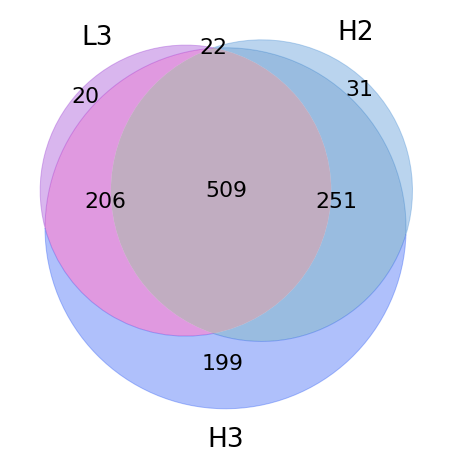

In [ ]:
plt.rcParams.update({'font.size': 22})
plt.figure(figsize=(8,8))
vena = venn3([cdr_combis['L3'], cdr_combis['H2'], cdr_combis['H3']],
    set_labels = ('L3', 'H2', 'H3'))
# cena = venn3_circles([cdr_combis['L3'], cdr_combis['H2'], cdr_combis['H3']])
# v.get_patch_by_id('001').set_alpha(1.0)
vena.get_patch_by_id('100').set_color('#A04AD6')
vena.get_patch_by_id('010').set_color('#5495D6')
vena.get_patch_by_id('001').set_color('#3763F5')
# v.get_label_by_id('100').set_text('Unknown')
# v.get_label_by_id('A').set_text('Set "A"')

# c[0].set_lw(1.0)
# c[0].set_ls('dotted')
# plt.title("Sample Venn diagram")
# plt.annotate('Unknown set', xy=v.get_label_by_id('100').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
#              ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
#              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.savefig(Path.joinpath(casa_dir, "more_plots", "SI_venn_cdr_3.jpg"),
    bbox_inches = 'tight')
plt.show()

### venn_combis_cdrs_4

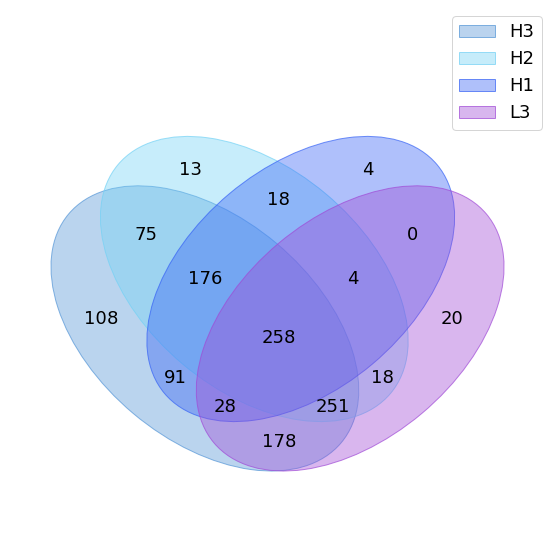

In [ ]:
venn(cdr_combis,
    cmap = ["#5495D6", "#74D2F5", "#3763F5", "#A04AD6"],
    fontsize = 18, ax = None, figsize = (10, 10))
plt.savefig(Path.joinpath(casa_dir, "more_plots", "SI_venn_cdr_4.jpg"),
    bbox_inches = 'tight')
plt.show()

### venn_combis_cdrs_3b

In [ ]:
fix_light_chain = {'H': 'H', 'K': 'L', 'L': 'L'}
cdr_combis = defaultdict(set)

for pdb_idcode in pdb_list:
    cdrs_cluster = [ fix_light_chain[atm.chain_type]+str(atm.CDR) for atm in hydrophobic[pdb_idcode][0] 
    if atm.CDR not in {0, -1}]

    for cdr in set(cdrs_cluster):
        if cdr in {'L1', 'L2', 'H1'}:
            continue
        cdr_combis[cdr].add(pdb_idcode)

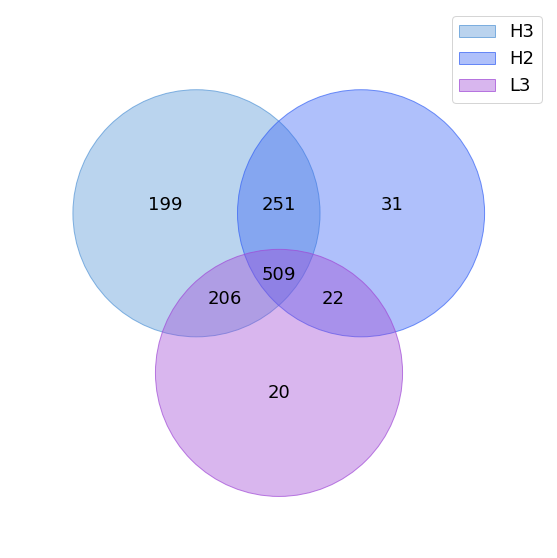

In [ ]:
venn(cdr_combis,
    cmap = ["#5495D6", "#3763F5", "#A04AD6"],
    fontsize = 18, ax = None, figsize = (10, 10))
plt.savefig(Path.joinpath(casa_dir, "more_plots", "SI_venn_cdr_3b.jpg"),
    bbox_inches = 'tight')
plt.show()

---

## DSSP population distributions

In [51]:
fig_5d = go.Figure()
fig_5d.add_trace(go.Bar(
    x = list(surface_sse.keys()),
    y = list(surface_sse.values()),
    name = "Ag surface", marker_color = 'Orange'))
fig_5d.add_trace(go.Bar(
    x = list(interface_sse.keys()),
    y = list(interface_sse.values()),
    name = "epitope", marker_color = 'Orange',
    marker_pattern_shape = 'x'))

fig_5d.update_xaxes(title = "SSE")
fig_5d.update_yaxes(title = "Probability", range=[0, .6])
fig_5d.update_layout(legend={'x': 0, 'y': 1},
    font_size=22, width=500, height=500)

In [61]:
mid_bins = np.linspace(0, 1, 11)
fig_si = go.Figure()
fig_si.add_trace(go.Histogram(x=list_interface_sse['H'],
    xbins=dict(start=0, end=1, size=.1),
    name = "Ag surface", marker_color = 'Orange',
    histnorm = 'probability'))
fig_si.add_trace(go.Histogram(x=list_surface_sse['H'],
    xbins=dict(start=0, end=1, size=.1),
    name = "epitope", marker_color = 'Orange',
    marker_pattern_shape = 'x', marker_pattern_bgcolor = 'Orange',
    marker_pattern_fgcolor = 'Gray',
    histnorm = 'probability'))

fig_si.update_xaxes(tick0 = 0, dtick=.1)
fig_si.update_xaxes(title = "Fraction of residues in α-helix conformation")
fig_si.update_yaxes(title = "Relative frequency", range=[0, .5])
fig_si.update_layout(legend={'x': 0.75, 'y': 1},
    font_size=22, width=800, height=500)

In [62]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_population_H.jpg"))

In [63]:
mid_bins = np.linspace(0, 1, 11)
fig_si = go.Figure()
fig_si.add_trace(go.Histogram(x=list_interface_sse['E'],
    xbins=dict(start=0, end=1, size=.1),
    name = "Ag surface", marker_color = 'Orange',
    histnorm = 'probability'))
fig_si.add_trace(go.Histogram(x=list_surface_sse['E'],
    xbins=dict(start=0, end=1, size=.1),
    name = "epitope", marker_color = 'Orange',
    marker_pattern_shape = 'x', marker_pattern_bgcolor = 'Orange',
    marker_pattern_fgcolor = 'Gray',
    histnorm = 'probability'))

fig_si.update_xaxes(tick0 = 0, dtick=.1)
fig_si.update_xaxes(title = "Fraction of residues in β-strand conformation")
fig_si.update_yaxes(title = "Relative frequency", range=[0, .5])
# fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=800, height=500)

In [64]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_population_E.jpg"))

In [65]:
mid_bins = np.linspace(0, 1, 11)
fig_si = go.Figure()
fig_si.add_trace(go.Histogram(x=list_interface_sse['C'],
    xbins=dict(start=0, end=1, size=.1),
    name = "Ag surface", marker_color = 'Orange',
    histnorm = 'probability'))
fig_si.add_trace(go.Histogram(x=list_surface_sse['C'],
    xbins=dict(start=0, end=1, size=.1),
    name = "epitope", marker_color = 'Orange',
    marker_pattern_shape = 'x', marker_pattern_bgcolor = 'Orange',
    marker_pattern_fgcolor = 'Gray',
    histnorm = 'probability'))

fig_si.update_xaxes(tick0 = 0, dtick=.1)
fig_si.update_xaxes(title = "Fraction of residues in coil conformation")
fig_si.update_yaxes(title = "Relative frequency", range=[0, .5])
# fig_si.update_traces(marker = {'color': 'BurlyWood'})
fig_si.update_layout(font_size=20, width=800, height=500)

In [66]:
fig_si.write_image(Path.joinpath(casa_dir, "more_plots", "SI_population_C.jpg"))

In [33]:
awalter_interface = pd.concat([pd.DataFrame(list_interface_sse),
    pd.Series(pdb_list, name = "pdb_idcode")], axis = 1)

awalter_surface = pd.concat([pd.DataFrame(list_surface_sse),
    pd.Series(pdb_list, name = "pdb_idcode")], axis = 1)

In [34]:
awalter_interface.to_csv("/home/pbarletta/labo/22/abag/data/dssp_epitope.csv", sep = '\t')
awalter_surface.to_csv("/home/pbarletta/labo/22/abag/data/dssp_surface.csv", sep = '\t')

In [17]:
np.mean(list_interface_sse['E']), np.std(list_interface_sse['E'])

(0.24881824988654877, 0.1986725438339402)

In [18]:
np.mean(list_interface_sse['C']), np.std(list_interface_sse['C'])

(0.5709576596078039, 0.20578995570046132)